data/data.csv
有重複資料
562 => 522

In [1]:

import time
import math
import json
import pickle

import statistics

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt

from os import listdir
from os.path import join
from os.path import isfile

from itertools import combinations

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import datasets
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


from libsvm.svmutil import svm_problem
from libsvm.svmutil import svm_parameter
from libsvm.svmutil import svm_train
from libsvm.svmutil import svm_predict
from libsvm.svmutil import evaluations

from Function import svm_function

In [2]:
k2nor2n3 = np.load("data/linear_features/point/benchmark/train/k2p10nor2n3_train.npy")
k3nor2n3 = np.load("data/linear_features/point/benchmark/train/k3p10nor2n3_train.npy")
k4nor2n3 = np.load("data/linear_features/point/benchmark/train/k4p10nor2n3_train.npy")

In [3]:
print(k2nor2n3.shape)
print(k3nor2n3.shape)
print(k4nor2n3.shape)

(2264, 48)
(2264, 192)
(2264, 768)


In [5]:
k234nor2n3 = np.append(k2nor2n3, k3nor2n3, axis=1)
k234nor2n3 = np.append(k234nor2n3, k4nor2n3, axis=1)
print(k234nor2n3.shape)


(2264, 1008)


In [6]:
np.save("data/linear_features/point/benchmark/train/k234p10nor2n3_train.npy", k234nor2n3)

In [13]:
data_path = "data/merge_data/0916chiu/classifier/"
file_str = "nuc_lncRNA__cyto_lncRNA"
test_x = np.load(data_path + file_str + "_test.npy")
test_y = np.load(data_path + file_str + "_test_y.npy")

with open("data/model/merge_data/0916chiu/classifier/nuc_lncRNA__cyto_lncRNA__svm.pickle", 'rb') as f:
    lncrna_clf = pickle.load(f)

with open("data/model/merge_data/0916chiu/classifier/nuc_mRNA__cyto_mRNA__svm.pickle", 'rb') as f:
    mrna_clf = pickle.load(f)

lnc_pred_y = lncrna_clf.predict(test_x)
m_pred_y = mrna_clf.predict(test_x)

In [14]:
file_str = "nuc_lncRNA__cyto_lncRNA + nuc_mRNA__cyto_mRNA"
decision_values = np.logical_or(lnc_pred_y, m_pred_y)
test_roc_score = metrics.roc_auc_score(test_y, decision_values)
        
tn, fp, fn, tp = confusion_matrix(test_y, decision_values).ravel()

acc = (tn + tp) / (tn + fp + fn + tp)
recall = tp / (fn + tp)
prec = (tp / (fp + tp))
spec = (tn / (tn + fp))
npv = (tn / (tn + fn))
f1sc = (2 * (tp / (fn + tp)) * (tp / (fp + tp)) / ((tp / (fn + tp)) + (tp / (fp + tp))))
print(file_str, test_roc_score, acc, recall, prec, spec, npv, f1sc)
# perf_list.append([file_str, train_auroc, test_roc_score, acc, recall, prec, spec, npv, f1sc])
print("AUROC: %.2f" % (test_roc_score))

nuc_lncRNA__cyto_lncRNA + nuc_mRNA__cyto_mRNA 0.6041520281060364 0.798941798941799 0.8534653465346534 0.9150743099787686 0.3548387096774194 0.22916666666666666 0.8831967213114755
AUROC: 0.60


In [7]:
dir_path = "data/model/merge_data/0916chiu/classifier/"
onlyfiles = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]

perf_list = []

for file_name in onlyfiles:
    if not ".dvc" in file_name and not ".git" in file_name:
        
        file_str = file_name[:-12]
        print(file_str)

        hpo_file = "data/merge_data/0916chiu/classifier/output/%s_train_svmf10p4e512" % file_str
        
        train_auroc = pd.read_csv(hpo_file)['value'][0]
        
        with open(dir_path + file_name, 'rb') as f:
            clf = pickle.load(f)
        
        data_path = "data/merge_data/0916chiu/classifier/"
        test_x = np.load(data_path + file_str + "_test.npy")
        test_y = np.load(data_path + file_str + "_test_y.npy")
        
        
        decision_values = clf.predict(test_x)
        # decision_values = np.where(np.isfinite(decision_values), decision_values, 0) 
        test_roc_score = metrics.roc_auc_score(test_y, decision_values)
        
        tn, fp, fn, tp = confusion_matrix(test_y, decision_values).ravel()
        
        acc = (tn + tp) / (tn + fp + fn + tp)
        recall = tp / (fn + tp)
        prec = (tp / (fp + tp))
        spec = (tn / (tn + fp))
        npv = (tn / (tn + fn))
        f1sc = (2 * (tp / (fn + tp)) * (tp / (fp + tp)) / ((tp / (fn + tp)) + (tp / (fp + tp))))
        
        perf_list.append([file_str, train_auroc, test_roc_score, acc, recall, prec, spec, npv, f1sc])
        print("AUROC: %.2f" % (test_roc_score))
perf_list

nuc_mRNA__cyto_mRNA
AUROC: 0.66
nuc_lncRNA__cyto_mRNA
AUROC: 0.82
nuc_lncRNA__cyto_lncRNA__cyto_mRNA
AUROC: 0.81
nuc_lncRNA__cyto_lncRNA__nuc_mRNA__cyto_mRNA
AUROC: 0.66
nuc_lncRNA__cyto_lncRNA
AUROC: 0.62
nuc_lncRNA__nuc_mRNA__cyto_mRNA
AUROC: 0.66


[['nuc_mRNA__cyto_mRNA',
  0.7174077860279746,
  0.6632308118592408,
  0.6595339990489777,
  0.6375727348295926,
  0.7325692454632283,
  0.6888888888888889,
  0.5871212121212122,
  0.6817777777777778],
 ['nuc_lncRNA__cyto_mRNA',
  0.8868376581624592,
  0.8238393839383938,
  0.8277580071174377,
  0.80990099009901,
  0.736936936936937,
  0.8377777777777777,
  0.8870588235294118,
  0.7716981132075471],
 ['nuc_lncRNA__cyto_lncRNA__cyto_mRNA',
  0.8556242730233251,
  0.8093658014450094,
  0.8098159509202454,
  0.807920792079208,
  0.6915254237288135,
  0.8108108108108109,
  0.8893956670467503,
  0.7452054794520548],
 ['nuc_lncRNA__cyto_lncRNA__nuc_mRNA__cyto_mRNA',
  0.7070590347665607,
  0.6563870887641379,
  0.6576779026217229,
  0.6610070257611241,
  0.7711748633879781,
  0.6517671517671517,
  0.5199004975124378,
  0.7118537200504415],
 ['nuc_lncRNA__cyto_lncRNA',
  0.6894040694408792,
  0.6207122325135739,
  0.7654320987654321,
  0.805940594059406,
  0.920814479638009,
  0.4354838709677

In [8]:
dir_path = "data/model/merge_data/0916chiu/classifier/"
onlyfiles = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]

lncrna_perf_list = []
mrna_perf_list = []

for file_name in onlyfiles:
    if not ".dvc" in file_name and not ".git" in file_name:
        file_str = file_name[:-12]
        print(file_str)

        with open(dir_path + file_name, 'rb') as f:
            clf = pickle.load(f)
        
        data_path = "data/merge_data/0916chiu/classifier/"
        test_x = np.load(data_path + "nuc_lncRNA__cyto_lncRNA" + "_test.npy")
        test_y = np.load(data_path + "nuc_lncRNA__cyto_lncRNA" + "_test_y.npy")
        
        decision_values = clf.predict(test_x)
        # decision_values = np.where(np.isfinite(decision_values), decision_values, 0) 
        test_roc_score = metrics.roc_auc_score(test_y, decision_values)
        
        tn, fp, fn, tp = confusion_matrix(test_y, decision_values).ravel()
        
        acc = (tn + tp) / (tn + fp + fn + tp)
        recall = tp / (fn + tp)
        prec = (tp / (fp + tp))
        spec = (tn / (tn + fp))
        npv = (tn / (tn + fn))
        f1sc = (2 * (tp / (fn + tp)) * (tp / (fp + tp)) / ((tp / (fn + tp)) + (tp / (fp + tp))))
        
        lncrna_perf_list.append([file_str, test_roc_score, acc, recall, prec, spec, npv, f1sc])
        print("AUROC: %.2f" % (test_roc_score))
        
        test_x = np.load(data_path + "nuc_mRNA__cyto_mRNA" + "_test.npy")
        test_y = np.load(data_path + "nuc_mRNA__cyto_mRNA" + "_test_y.npy")
        
        decision_values = clf.predict(test_x)
        # decision_values = np.where(np.isfinite(decision_values), decision_values, 0) 
        test_roc_score = metrics.roc_auc_score(test_y, decision_values)
        
        tn, fp, fn, tp = confusion_matrix(test_y, decision_values).ravel()
        
        acc = (tn + tp) / (tn + fp + fn + tp)
        recall = tp / (fn + tp)
        prec = (tp / (fp + tp))
        spec = (tn / (tn + fp))
        npv = (tn / (tn + fn))
        f1sc = (2 * (tp / (fn + tp)) * (tp / (fp + tp)) / ((tp / (fn + tp)) + (tp / (fp + tp))))
        
        mrna_perf_list.append([file_str, test_roc_score, acc, recall, prec, spec, npv, f1sc])
        print("AUROC: %.2f" % (test_roc_score))
        

nuc_mRNA__cyto_mRNA
AUROC: 0.56
AUROC: 0.66
nuc_lncRNA__cyto_mRNA
AUROC: 0.52
AUROC: 0.51
nuc_lncRNA__cyto_lncRNA__cyto_mRNA
AUROC: 0.60
AUROC: 0.51
nuc_lncRNA__cyto_lncRNA__nuc_mRNA__cyto_mRNA
AUROC: 0.58
AUROC: 0.65
nuc_lncRNA__cyto_lncRNA
AUROC: 0.62
AUROC: 0.59
nuc_lncRNA__nuc_mRNA__cyto_mRNA
AUROC: 0.54
AUROC: 0.64


In [9]:
indep_list = [["nuc_mRNA__cyto_mRNA", "nuc_lncRNA__cyto_lncRNA"],
              ["nuc_lncRNA__cyto_mRNA", "nuc_mRNA__cyto_lncRNA"],
              ["nuc_lncRNA__cyto_lncRNA", "nuc_mRNA__cyto_mRNA"],
              ["nuc_lncRNA__cyto_lncRNA__cyto_mRNA", "nuc_mRNA"],
              ["nuc_lncRNA__nuc_mRNA__cyto_mRNA", "cyto_lncRNA"],
              ]
indep_perf_list = []
for test_str in indep_list:
    print(test_str[0], test_str[1])
    file_str = test_str[1]
    with open(dir_path + test_str[0] + "__svm.pickle", 'rb') as f:
        clf = pickle.load(f)
    
    data_path = "data/merge_data/0916chiu/classifier/"
    test_x = np.load(data_path + file_str + "_test.npy")
    test_y = np.load(data_path + file_str + "_test_y.npy")
    
    decision_values = clf.predict(test_x)
    # decision_values = np.where(np.isfinite(decision_values), decision_values, 0) 
    if "nuc_mRNA" == file_str or "cyto_lncRNA" == file_str:
        test_roc_score = metrics.accuracy_score(test_y, decision_values)
    else:
        test_roc_score = metrics.roc_auc_score(test_y, decision_values)
    print("AUROC: %.2f" % (test_roc_score))
    tn, fp, fn, tp = confusion_matrix(test_y, decision_values).ravel()
        
    acc = (tn + tp) / (tn + fp + fn + tp)
    recall = tp / (fn + tp)
    prec = (tp / (fp + tp))
    spec = (tn / (tn + fp))
    npv = (tn / (tn + fn))
    f1sc = (2 * (tp / (fn + tp)) * (tp / (fp + tp)) / ((tp / (fn + tp)) + (tp / (fp + tp))))
    
    indep_perf_list.append([test_str[0], file_str, test_roc_score, acc, recall, prec, spec, npv, f1sc])

nuc_mRNA__cyto_mRNA nuc_lncRNA__cyto_lncRNA
AUROC: 0.56
nuc_lncRNA__cyto_mRNA nuc_mRNA__cyto_lncRNA
AUROC: 0.20
nuc_lncRNA__cyto_lncRNA nuc_mRNA__cyto_mRNA
AUROC: 0.59
nuc_lncRNA__cyto_lncRNA__cyto_mRNA nuc_mRNA
AUROC: 0.19
nuc_lncRNA__nuc_mRNA__cyto_mRNA cyto_lncRNA
AUROC: 0.31


/home/jand/.conda/envs/jand_venv/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars
/home/jand/.conda/envs/jand_venv/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars
/home/jand/.conda/envs/jand_venv/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in long_scalars


In [10]:
df = pd.DataFrame(perf_list, columns=["model", "train AUROC", "test AUROC", "acc test", "recall test", "prec test", "spec test", "npv test", "f1sc test"])
lnc_df = pd.DataFrame(lncrna_perf_list, columns=["model", "lncRNA AUROC", "acc lncRNA", "recall lncRNA", "prec lncRNA", "spec lncRNA", "npv lncRNA", "f1sc lncRNA"])
m_df = pd.DataFrame(mrna_perf_list, columns=["model", "mRNA AUROC", "acc mRNA", "recall mRNA", "prec mRNA", "spec mRNA", "npv mRNA", "f1sc mRNA"])
df1 = pd.DataFrame(indep_perf_list, columns=["model", "indep name", "indep AUROC", "acc indep", "recall indep", "prec indep", "spec indep", "npv indep", "f1sc indep"])
# pd.merge(df, df1, on="model", how="left").to_csv("data/model/output/mRNA_lncRNA__svm_v1.csv", index=False)

In [11]:
merge_df = pd.merge(df, lnc_df, on="model", how="left")
merge_df = pd.merge(merge_df, m_df, on="model", how="left")
merge_df = pd.merge(merge_df, df1, on="model", how="left")
merge_df.to_csv("data/model/output/mRNA_lncRNA__svm_v4.csv", index=False)

In [35]:
c_lncRNA = np.load("data/merge_data/0916chiu/cyto_lncRNA_train.npy")
n_lncRNA = np.load("data/merge_data/0916chiu/nuc_lncRNA_train.npy")
c_mRNA = np.load("data/merge_data/0916chiu/cyto_mRNA_train.npy")
n_mRNA = np.load("data/merge_data/0916chiu/nuc_mRNA_train.npy")


In [37]:
# train = n_mRNA
train = np.append(c_lncRNA, n_lncRNA, axis=0)
# train = np.append(train, c_lncRNA, axis=0)
# train = np.append(train, n_lncRNA, axis=0)
# train_y = np.ones(len(n_mRNA))
train_y = np.append(np.zeros(len(c_lncRNA)), np.ones(len(n_lncRNA)))
# train_y = np.append(train_y, np.zeros(len(c_lncRNA)))
# train_y = np.append(train_y, np.ones(len(n_lncRNA)))

In [39]:
idx = np.arange(len(train_y))
np.random.seed(1212)
np.random.shuffle(idx)

In [41]:
np.save("data/merge_data/0916chiu/classifier/nuc_lncRNA__cyto_lncRNA_train.npy", train)
np.save("data/merge_data/0916chiu/classifier/nuc_lncRNA__cyto_lncRNA_train_y.npy", train_y)

In [40]:
print(train.shape)
print(train_y.shape)

(2264, 196)
(2264,)


In [56]:
print(c_lncRNA.shape)
print(n_lncRNA.shape)
print(c_mRNA.shape)
print(n_mRNA.shape)

(302, 196)
(1962, 196)
(3597, 196)
(4811, 196)


In [46]:
y = np.load("data/linear_features/point/benchmark/benchmark_y.npy")
idx = np.arange(len(y))
np.random.shuffle(idx)
split_idx = int(len(idx) * 0.8)
np.save("data/linear_features/linear/benchmark/train/train_y.npy", y[idx[:split_idx]])
np.save("data/linear_features/linear/benchmark/test/test_y.npy", y[idx[split_idx:]])

for k in [1, 2, 3, 4]:
    for nor in [0, 1, 2, 3]:
        x = np.load("data/linear_features/linear/benchmark/k%sp10nor%s.npy" % (k, nor))
        x = x.reshape(x.shape[0],-1)
        np.save("data/linear_features/linear/benchmark/train/k%sp10nor%s_train.npy" % (k, nor), x[idx[:split_idx]])
        np.save("data/linear_features/linear/benchmark/test/k%sp10nor%s_test.npy" % (k, nor), x[idx[split_idx:]])

In [ ]:
dir_path = "data/merge_data/0916chiu/classifier/"
onlyfiles = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]


output_dir_path = "data/merge_data/0916chiu/classifier/output/"
outputfiles = [f for f in listdir(output_dir_path) if isfile(join(output_dir_path, f))]
s = ""
for file_name in outputfiles:
    # file_str = file_name.split(".")[0]
    # print(file_str + "_libsvmf10p4e512" , )
    if not ".dvc" in file_name and not ".json" in file_name and "nuc_lncRNA__cyto_lncRNA_train_svmf10p4e512" == file_name:
    # if not ".dvc" in file_name and "train.npy" in file_name and not file_str + "_svmf10p4e512" in outputfiles:
    # if not ".dvc" in file_name and "train.npy" in file_name:
        file_str = file_name[:-19]
        dir_file = dir_path + file_str
        output_dir_file = output_dir_path + file_str
        # label_file = dir_path + file_str + "_y.npy"
        s = s + "nohup python save_model.py -x %s_train.npy -y %s_train_y.npy -i %s_test.npy -l %s_test_y.npy -p %s_train_svmf10p4e512 --save data/model/merge_data/0916chiu/classifier/%s__svm.pickle &> save_model__%s__svm.txt & \n" % (dir_file, dir_file, dir_file, dir_file, output_dir_file, file_str, file_str)
        # s = s + "nohup python hpo_svm_train.py -m svm -p 4 -e 512 -f 10 -i %s -l %s -o %s_svmf10p4e512 &> %s_svmf10p4e512.txt & \n" % (dir_path + file_name, label_file, output_dir_path + file_str, "data/log/" + file_str)
        # s = s + "nohup python hpo_svm_train.py -m esvm -s 10 -p 4 -e 512 -f 10 -i %s -l %s -o %s_esvmf10p4e512s10 &> %s_esvmf10p4e512s10.txt & \n" % (dir_path + file_name, label_file, output_dir_path + file_str, "data/log/" + file_str)
        
with open('svm.sh', 'w') as fp:
    fp.write(s)

In [6]:
dir_path = "data/merge_data/0916chiu/classifier/"

output_dir_path = "data/merge_data/0916chiu/classifier/output/"

file_name = "nuc_lncRNA__nuc_mRNA__cyto_mRNA_svmf10p4e512"
file_str = "nuc_lncRNA__nuc_mRNA__cyto_mRNA"
dir_file = dir_path + file_str
output_dir_file = output_dir_path + file_str
s = "nohup python save_model.py -x %s_train.npy -y %s_train_y.npy -i %s_test.npy -l %s_test_y.npy -p %s_train_svmf10p4e512 --save data/model/merge_data/0916chiu/classifier/%s__svm.pickle &> data/log/save_model__%s__svm.txt & \n" % (dir_file, dir_file, dir_file, dir_file, output_dir_file, file_str, file_str)
print(s)

nohup python save_model.py -x data/merge_data/0916chiu/classifier/nuc_lncRNA__nuc_mRNA__cyto_mRNA_train.npy -y data/merge_data/0916chiu/classifier/nuc_lncRNA__nuc_mRNA__cyto_mRNA_train_y.npy -i data/merge_data/0916chiu/classifier/nuc_lncRNA__nuc_mRNA__cyto_mRNA_test.npy -l data/merge_data/0916chiu/classifier/nuc_lncRNA__nuc_mRNA__cyto_mRNA_test_y.npy -p data/merge_data/0916chiu/classifier/output/nuc_lncRNA__nuc_mRNA__cyto_mRNA_train_svmf10p4e512 --save data/model/merge_data/0916chiu/classifier/nuc_lncRNA__nuc_mRNA__cyto_mRNA__svm.pickle &> data/log/save_model__nuc_lncRNA__nuc_mRNA__cyto_mRNA__svm.txt & 



In [10]:
def svm_train_model_hp_object(x, y, hp_object, max_iter=1e7):
    # if np.isnan(hp_object['logGamma']):
    #     print(hp_object['logGamma'])
    # print(hp_object['kernel'], hp_object['C'], hp_object['logGamma'], hp_object['degree'], hp_object['coef0'])
    clf = svm_function.svm_train_model(x_train=x, y_train=y, kernel=hp_object['kernel'], C=hp_object['C'], logGamma=hp_object['logGamma'], degree=hp_object['degree'], coef0=hp_object['coef0'], n=None, max_iter=max_iter)
    return clf

In [4]:
dir_path = "data/ensemble_data/combination/"
onlyfiles = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]


output_dir_path = "data/ensemble_data/output/combination/"
outputfiles = [f for f in listdir(output_dir_path) if isfile(join(output_dir_path, f))]
for file_name in outputfiles:
    if not "." in file_name and "_111111_" in file_name:
        db_name = file_name.split("_")[0]
        file_str = ("_").join(file_name.split("_")[:3])
        
        if db_name == "ensembl":
            label_file = "data/ensemble_data/combination/ensembl_combination_train_y.npy"
            label_test_file = "data/ensemble_data/combination/ensembl_combination_test_y.npy"
        else:
            label_file = "data/ensemble_data/combination/rnaatlas_combination_train_y.npy"
            label_test_file = "data/ensemble_data/combination/rnaatlas_combination_test_y.npy"
        print(file_name, file_str)
        df = pd.read_csv(output_dir_path + file_name)
        # print(dir_path + file_name, label_file)
        x = np.load(dir_path + file_str + "_train.npy")
        x_test = np.load(dir_path + file_str + "_test.npy")
        y = np.load(label_file)
        y_test = np.load(label_test_file)
        # print(df.iloc[0])
        model = svm_train_model_hp_object(x, y, df.iloc[0])
        decision_values = model.decision_function(x_test)
        # decision_values = np.where(np.isfinite(decision_values), decision_values, 0) 
        roc_score = metrics.roc_auc_score(y_test, decision_values)
        print(roc_score)
        break

ensembl_combination_111111_train_svmf10p4e512 ensembl_combination_111111
0.6883063084388686


In [11]:
# ensembl_combination_111111_train_svmf10p4e512
# db_name = 'ensembl'
db_name = 'rnaatlas'
file_str = "rnaatlas_combination_11112"
file_name = "rnaatlas_combination_11112_train_svmf10p4e512"
dir_path = "data/ensemble_data/combination/"
output_dir_path = "data/ensemble_data/output/combination/"

if db_name == "ensembl":
    label_file = "data/ensemble_data/combination/ensembl_combination_train_y.npy"
    label_test_file = "data/ensemble_data/combination/ensembl_combination_test_y.npy"
    df = pd.read_csv("data/ensemble_data/merge_e.csv")
    test_id = np.load('data/ensemble_data/combination/ensembl_combination_test_yid.npy')
    
else:
    label_file = "data/ensemble_data/combination/rnaatlas_combination_train_y.npy"
    label_test_file = "data/ensemble_data/combination/rnaatlas_combination_test_y.npy"
    df = pd.read_csv("data/ensemble_data/merge_r.csv")
    test_id = np.load('data/ensemble_data/combination/rnaatlas_combination_test_yid.npy')
    
# df = df[["iloclncrna_N", "lnclocator_N", "lnclocpred_N", "locater_N", "lnclocatorv2_CNRCI_Value"]]
df = df[["iloclncrna_N", "lnclocator_N", "lnclocpred_N", "locater_N", "lnclocatorv2_CNRCI_Value_nor_N"]]
# df = df[["deeplncrna_N", "iloclncrna_N", "lnclocator_N", "lnclocpred_N", "locater_N", "lnclocatorv2_CNRCI_Value"]]
# df = df[["deeplncrna_N", "iloclncrna_N", "lnclocator_N", "lnclocpred_N", "locater_N", "lnclocatorv2_CNRCI_Value_nor_N"]]    

print(file_name, file_str)

x = np.load(dir_path + file_str + "_train.npy")
# x_test = np.load(dir_path + file_str + "_test.npy")
x_test = df.iloc[test_id]

y = np.load(label_file)
y_test = np.load(label_test_file)

df = pd.read_csv(output_dir_path + file_name)
print(df.iloc[0])

model = svm_train_model_hp_object(x, y, df.iloc[0])
decision_values = model.decision_function(x_test)
# decision_values = np.where(np.isfinite(decision_values), decision_values, 0) 
roc_score = metrics.roc_auc_score(y_test, decision_values)
print(roc_score)


rnaatlas_combination_11112_train_svmf10p4e512 rnaatlas_combination_11112
Unnamed: 0        448
degree        5.85231
kernel         C_poly
C             3.39226
logGamma       -5.807
coef0          3.2085
value         0.61677
Name: 0, dtype: object
0.5871146245059289


In [22]:
temp1 = pd.read_csv("data/merge_data/0916chiu/mRNA_in_APEX_Kmer_k3.csv", header=None).to_numpy()
temp2 = pd.read_csv("data/merge_data/0916chiu/mRNA_in_APEX_DACC_lag2.csv", header=None).to_numpy()
temp = np.append(temp1, temp2, axis=1)
temp1 = pd.read_csv("data/merge_data/0916chiu/mRNA_in_APEX_SC-PseDNC-General_all_index.csv", header=None).to_numpy()
test = np.append(temp, temp1, axis=1)

In [5]:
model = pickle.load(open("data/model/merge_data/Kmer_k3__DACC_lag2__SC-PseDNC-General_all_index", 'rb'))

In [25]:
df = pd.read_csv("data/Chiu/mRNA_in_APEX.csv")
df['predict'] = decision_values

In [27]:
df[["transcript ID", "predict"]].to_csv("data/model/output/merge_data_output.csv", index=False)

In [24]:
decision_values = model.predict(test)
decision_values[:20]

array([0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       1., 0., 1.])

In [ ]:
model = svm_train_model_hp_object(x, y, df.iloc[0])
decision_values = model.decision_function(test)
# decision_values = np.where(np.isfinite(decision_values), decision_values, 0) 
# roc_score = metrics.roc_auc_score(y_test, decision_values)
print(roc_score)

In [12]:
output_dir_path = "data/merge_data/output/"
train_dir_path = "data/merge_data/train/"
test_dir_path = "data/merge_data/test/"
file_name = "Kmer_k3__DACC_lag2__SC-PseDNC-General_all_index_svmf10p4e512"
file_str = file_name[:-len('_svmf10p4e512')]

print(file_str)

df = pd.read_csv(output_dir_path + file_name)
x = np.load(train_dir_path + file_str + "_train.npy")
x_test = pd.read_csv(test_dir_path + file_str + "_test.csv")
# x_test = np.load(test_dir_path + file_str + "_test.npy")
y = np.load(train_dir_path + "train_y.npy")
y_test = np.load(test_dir_path + "test_y.npy")

model = svm_train_model_hp_object(x, y, df.iloc[0])
decision_values = model.decision_function(x_test)
# decision_values = np.where(np.isfinite(decision_values), decision_values, 0) 
roc_score = metrics.roc_auc_score(y_test, decision_values)
print(roc_score)

Kmer_k3__DACC_lag2__SC-PseDNC-General_all_index
0.6869370808048547


In [4]:
import shap
shap.initjs()
# explainer = shap.KernelExplainer(model.predict)

In [5]:
def print_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(x_test) == y_test)/len(y_test)))
    time.sleep(0.5) # to let the print get out before any progress bars

In [5]:
f = lambda x: model.predict_proba(x)[:,1]
explainer = shap.Explainer(f, x)
shap_values = explainer(x_test)

Permutation explainer:  54%|█████▍    | 306/567 [1:26:45<1:13:54, 16.99s/it]

rnaatlas_combination_11112


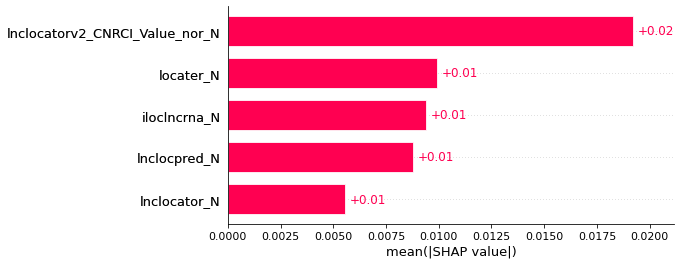

In [65]:
fig = shap.plots.bar(shap_values, show=False)
plt.savefig('data/output_img/shap_png_%s_bar.png' % file_str)
print(file_str)

rnaatlas_combination_11112


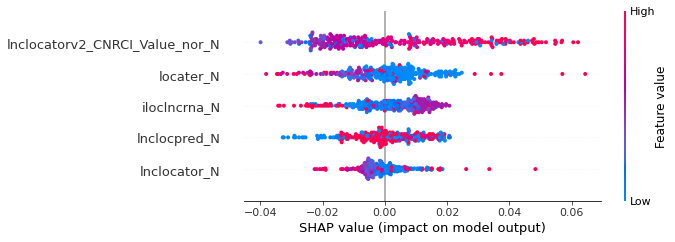

In [66]:
fig = shap.plots.beeswarm(shap_values, show=False)
plt.savefig('data/output_img/shap_png_%s_beeswarm.png' % file_str)
print(file_str)

rnaatlas_combination_11112


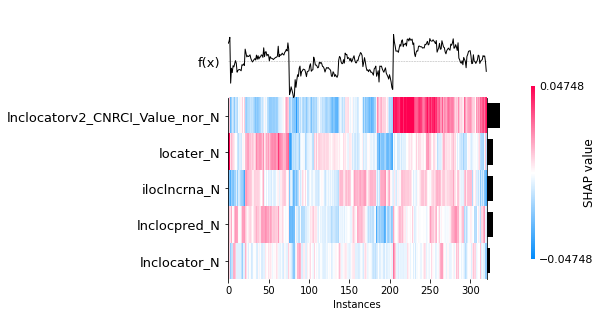

In [67]:
fig = shap.plots.heatmap(shap_values, show=False)
plt.savefig('data/output_img/shap_png_%s_heatmap.png' % file_str)
print(file_str)

rnaatlas_combination_11112


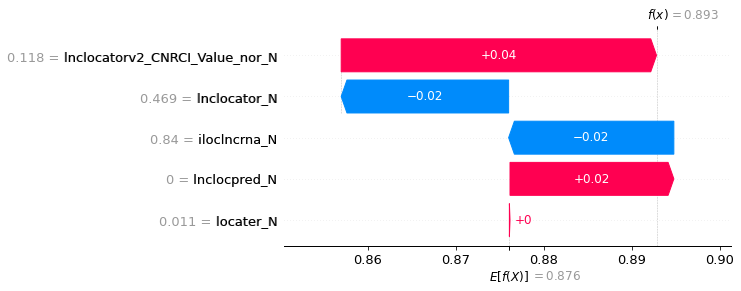

In [68]:
fig = shap.plots.waterfall(shap_values[0], show=False)
plt.savefig('data/output_img/shap_png_%s_waterfall.png' % file_str)
print(file_str)

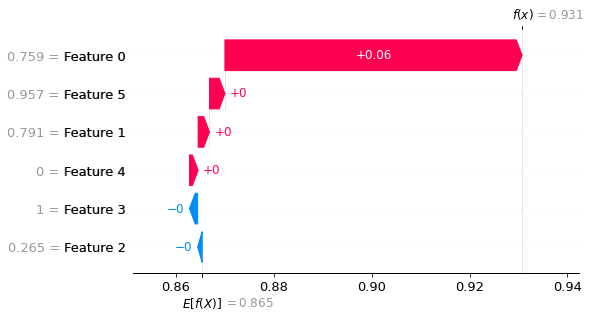

In [9]:
#ensembl_combination_111111
shap.plots.waterfall(shap_values[0])

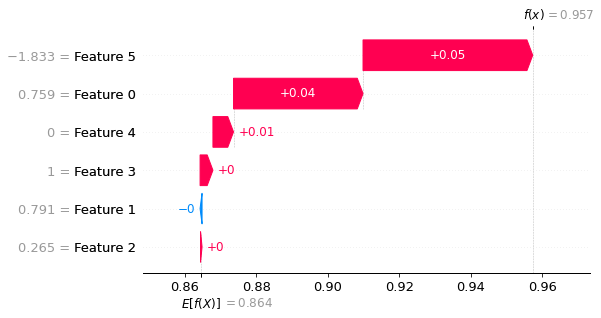

In [12]:
#ensembl_combination_111111
shap.plots.waterfall(shap_values[0])

In [26]:
# col_array = ['deeplncrna_N', 'iloclncrna_N', 'lnclocator_N', 'lnclocpred_N', 'locater_N']
# col_v2_array = ['', 'lnclocatorv2_CNRCI_Value', 'lnclocatorv2_CNRCI_Value_nor_N']

dir_path = "data/ensemble_data/output/combination/"
onlyfiles = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]
df = None
i = 0
for file_name in onlyfiles:
    if not "." in file_name and "train_svmf10p4e512" in file_name:
        i += 1
        hp_df = pd.read_csv(dir_path + file_name)
        
        bin_str = file_name.split("_")[2]
        if len(bin_str) < 6:
            bin_str = '0' + bin_str

        with open(dir_path + file_name + ".json") as f:
            json_dict = json.load(f)
        json_dict = {
            "DB": file_name.split("_")[0],
            "deeplncrna": bin_str[0],
            "iloclncrna": bin_str[1],
            "lnclocator": bin_str[2],
            "lnclocpred": bin_str[3],
            "locater": bin_str[4],
            "lnclocator_v2": bin_str[5],
            # "combination": "'" + file_name.split("_")[2] + "'",
            "kernel": hp_df["kernel"][0],
            "C": hp_df["C"][0],
            "degree": hp_df["degree"][0],
            "coef0": hp_df["coef0"][0],
            "logGamma": hp_df["logGamma"][0],
            "avg Accy": [json_dict["avg Accy"]],
            "std Accy": [json_dict["std Accy"]],
            "avg Recall": [json_dict["avg Recall"]],
            "std Recall": [json_dict["std Recall"]],
            "avg Prec": [json_dict["avg Prec"]],
            "std Prec": [json_dict["std Prec"]],
            "avg Spec": [json_dict["avg Spec"]],
            "std Spec": [json_dict["std Spec"]],
            "avg F1sc": [json_dict["avg F1sc"]],
            "std F1sc": [json_dict["std F1sc"]],
            "avg AUROC": [json_dict["avg AUROC"]],
            "std AUROC": [json_dict["std AUROC"]],
            "fold Accy": [json_dict["fold Accy"]],
            "fold Recall": [json_dict["fold Recall"]],
            "fold Prec": [json_dict["fold Prec"]],
            "fold Spec": [json_dict["fold Spec"]],
            "fold F1sc": [json_dict["fold F1sc"]],
            "fold AUROC": [json_dict["fold AUROC"]],
            "confusion matrix": [json_dict["confusion matrix"]],
        }
        if df is None:
            df = pd.DataFrame(json_dict)
        else:
            df = df.append(pd.DataFrame(json_dict))
print(i)

102


In [28]:
df.to_csv("data/ensemble_data/output/combination/svmf10p4e512_top1_perf.csv", index=False)

In [29]:
dir_path = "data/ensemble_data/combination/"
onlyfiles = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]


output_dir_path = "data/ensemble_data/output/combination/"
outputfiles = [f for f in listdir(output_dir_path) if isfile(join(output_dir_path, f))]
s = ""
for file_name in onlyfiles:
    db_name = file_name.split("_")[0]
    file_str = file_name.split(".")[0]
    # print(file_str + "_libsvmf10p4e512" , )
    if not ".dvc" in file_name and "train.npy" in file_name and not file_str + "_esvmf10p4e512s10" in outputfiles and (["_111111_", "_111112_", "_111112_", "_111112_"]):
    # if not ".dvc" in file_name and "train.npy" in file_name:
        
        if db_name == "ensembl":
            label_file = "data/ensemble_data/combination/ensembl_combination_train_y.npy"
        else:
            label_file = "data/ensemble_data/combination/rnaatlas_combination_train_y.npy"
            
        
        s = s + "nohup python hpo_svm_train.py -m svm -p 4 -e 512 -f 10 -i %s -l %s -o %s_svmf10p4e512 &> %s_svmf10p4e512.txt & \n" % (dir_path + file_name, label_file, output_dir_path + file_str, "data/log/" + file_str)
        # s = s + "nohup python hpo_svm_train.py -m esvm -s 10 -p 4 -e 512 -f 10 -i %s -l %s -o %s_esvmf10p4e512s10 &> %s_esvmf10p4e512s10.txt & \n" % (dir_path + file_name, label_file, output_dir_path + file_str, "data/log/" + file_str)
        
with open('svm.sh', 'w') as fp:
    fp.write(s)

In [16]:
col_array = ['deeplncrna_N', 'iloclncrna_N', 'lnclocator_N', 'lnclocpred_N', 'locater_N', 'lnclocatorv2_CNRCI_Value', 'lnclocatorv2_CNRCI_Value_nor_N']
merge_df = pd.read_csv("data/ensemble_data/merge_e.csv")
db_name = "ensembl"
# db_name = "rnaatlas"
train_id = np.load("data/ensemble_data/combination/" + db_name + "_combination_train_yid.npy")
train_y = np.load("data/ensemble_data/combination/" + db_name + "_combination_train_y.npy")
train_df = merge_df.iloc[train_id]
print(train_y)
for col in col_array:
    roc_score = metrics.roc_auc_score(train_y, train_df[col].to_numpy())
    print(col, roc_score)
    
    # print(train_y, train_df[col].to_numpy())
# roc_score = metrics.roc_auc_score(train_y, decision_values)

[1 1 0 ... 1 1 0]
deeplncrna_N 0.681780888030888
iloclncrna_N 0.48950634307777163
lnclocator_N 0.4351454771097628
lnclocpred_N 0.468982694429123
locater_N 0.45303795504688366
lnclocatorv2_CNRCI_Value 0.44683018477661335
lnclocatorv2_CNRCI_Value_nor_N 0.5531698152233866


In [17]:
from sklearn.metrics import confusion_matrix


col_array = ['deeplncrna_N', 'iloclncrna_N', 'lnclocator_N', 'lnclocpred_N', 'locater_N', 'lnclocatorv2_CNRCI_Value', 'lnclocatorv2_CNRCI_Value_nor_N']
db_name = ["ensembl", 'rnaatlas']

df = None
for db in db_name:
    if db == 'ensembl':
        merge_df = pd.read_csv("data/ensemble_data/merge_e.csv")
    else:
        merge_df = pd.read_csv("data/ensemble_data/merge_r.csv")
    merge_loc = merge_df['loc'].replace(['C', 'N'], [0, 1]).to_numpy()
        
    for col in col_array:
    
        roc_score = metrics.roc_auc_score(merge_loc, merge_df[col].to_numpy())
        print(db, col, roc_score)
        
        tn, fp, fn, tp = confusion_matrix(merge_loc, merge_df[col]).ravel()
        
        json_dict = {
            'DB': db,
            'prediction name': col,
            "Accy": (tn + tp) / (tn + fp + fn + tp),
            "Recall": tp / (fn + tp),
            "Prec": tp / (fp + tp),
            "Spec": tn / (tn + fp),
            "F1sc": 2 * (tp / (fn + tp)) * (tp / (fp + tp)) / ((tp / (fn + tp)) + (tp / (fp + tp))),
            "AUROC": roc_score,
        }
        
        if df is None:
            df = pd.DataFrame(json_dict)
        else:
            df = df.append(pd.DataFrame(json_dict))

deeplncrna_N 0.6812337032117252
iloclncrna_N 0.48736397912222085
lnclocator_N 0.4386838232992079
lnclocpred_N 0.4750723432042113
locater_N 0.4509363245626982
lnclocatorv2_CNRCI_Value 0.4332977767043701
lnclocatorv2_CNRCI_Value_nor_N 0.5667022232956299


In [6]:
merge_df = pd.read_csv("data/ensemble_data/merge_e.csv")

col_array = ['deeplncrna_N', 'iloclncrna_N', 'lnclocator_N', 'lnclocpred_N', 'locater_N']
# col_array = ['iloclncrna_N', 'lnclocator_N', 'lnclocpred_N', 'locater_N']

col_v2_array = ['', 'lnclocatorv2_CNRCI_Value', 'lnclocatorv2_CNRCI_Value_nor_N']

merge_loc = merge_df['loc'].replace(['C', 'N'], [0, 1]).to_numpy()

idx = np.arange(len(merge_loc))
np.random.shuffle(idx)
split_idx = int(len(idx) * 0.8)
db_name = "ensembl"
# db_name = "rnaatlas"
np.save("data/ensemble_data/combination/" + db_name + "_combination_train_yid.npy", idx[:split_idx])
np.save("data/ensemble_data/combination/" + db_name + "_combination_test_yid.npy", idx[split_idx:])

np.save("data/ensemble_data/combination/" + db_name + "_combination_train_y.npy", merge_loc[idx[:split_idx]])
np.save("data/ensemble_data/combination/" + db_name + "_combination_test_y.npy", merge_loc[idx[split_idx:]])

dir_path = "data/ensemble_data/combination/"
onlyfiles = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]

for i in range(2 ** (len(col_array))):
    bin_str = '{0:05b}'.format(i)
    for k in range(3):
        df = pd.DataFrame([])
        for j in range(len(bin_str)):
            if bin_str[j] == '1':
                df[col_array[j]] = merge_df[col_array[j]]
        if k != 0:
            df[col_v2_array[k]] = merge_df[col_v2_array[k]]
        if len(df.columns) > 1:
            np.save("data/ensemble_data/combination/" + db_name + "_combination_" + bin_str + str(k) + "_train.npy", df.iloc[idx[:split_idx]].to_numpy())
            np.save("data/ensemble_data/combination/" + db_name + "_combination_" + bin_str + str(k)  + "_test.npy", df.iloc[idx[split_idx:]].to_numpy())

In [42]:
merge_df = pd.read_csv("data/ensemble_data/merge_r.csv")
merge_loc = merge_df['loc'].replace(['C', 'N'], [0, 1]).to_numpy()

idx = np.arange(len(merge_loc))
np.random.shuffle(idx)
split_idx = int(len(idx) * 0.8)

merge_df = merge_df.drop('Transcript_stable_ID', 1)
merge_df = merge_df.drop('loc', 1)

np.save("data/ensemble_data/rnaatlas_merge_train.npy", merge_df[:split_idx].to_numpy())
np.save("data/ensemble_data/rnaatlas_merge_train_y.npy", merge_loc[:split_idx])
np.save("data/ensemble_data/rnaatlas_merge_test.npy", merge_df[split_idx:].to_numpy())
np.save("data/ensemble_data/rnaatlas_merge_test_y.npy", merge_loc[split_idx:])

merge_df = merge_df.drop('lnclocatorv2_CNRCI_Value', 1)
np.save("data/ensemble_data/rnaatlas_merge_no_lnclocatorv2_train.npy", merge_df[:split_idx].to_numpy())
np.save("data/ensemble_data/rnaatlas_merge_no_lnclocatorv2_test.npy", merge_df[split_idx:].to_numpy())

In [39]:
np.load("data/ensemble_data/ensembl_merge_train.npy").shape

(2256, 11)

In [41]:
np.load("data/ensemble_data/ensembl_merge_no_lnclocatorv2_test.npy").shape

(565, 10)

In [5]:
dacc_lag2_train = np.load("data/Pse_in_One2/Chiu/train/benchmark_DACC_lag2_train.npy")
kmer_k3_train = np.load("data/Pse_in_One2/Chiu/train/benchmark_Kmer_k3_train.npy")
# sc_psednc_train = np.load("data/Pse_in_One2/Chiu/train/benchmark_SC-PseDNC-General_all_index_train.npy")
temp = np.append(kmer_k3_train, dacc_lag2_train, axis=1)
# temp = np.append(temp, sc_psednc_train, axis=1) 
print(temp.shape)
np.save("data/merge_data/train/Kmer_k3__DACC_lag2_train.npy", temp)

dacc_lag2_test = np.load("data/Pse_in_One2/Chiu/test/benchmark_DACC_lag2_test.npy")
kmer_k3_test = np.load("data/Pse_in_One2/Chiu/test/benchmark_Kmer_k3_test.npy")
# sc_psednc_test = np.load("data/Pse_in_One2/Chiu/test/benchmark_SC-PseDNC-General_all_index_test.npy")
temp = np.append(kmer_k3_test, dacc_lag2_test, axis=1)
# temp = np.append(temp, sc_psednc_test, axis=1) 
print(temp.shape)
np.save("data/merge_data/test/Kmer_k3__DACC_lag2_test.npy", temp)

(2264, 136)
(567, 136)


In [55]:
s = ""
dir_path = "data/Pse_in_One2/Chiu/train/"
onlyfiles = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]

dir_path = "data/Pse_in_One2/Chiu/output/"
output_files = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]

for file_name in onlyfiles:
    if not ".dvc" in file_name and "benchmark" in file_name :
        # print(file_name)
        
        if "all_index" in file_name or "Mismatch" in file_name:
            file_str = file_name.split("_")[1] + "_" + file_name.split("_")[2] + "_" + file_name.split("_")[3]
        elif not "-" in file_name:
            file_str = file_name.split("_")[1] + "_" + file_name.split("_")[2]
        else:
            file_str = file_name.split("_")[1]
        if not file_str in ["PseDPC_train.npy", "PseSSC_train.npy", "Triplet_train.npy"] and not file_str + "_esvmf10p4e512s200" in output_files:
            print(file_str)
            # s = s + "nohup python hpo_svm_train.py -m svm -p 4 -e 512 -f 10 -i data/Pse_in_One2/Chiu/train/benchmark_%s_train.npy -l data/Pse_in_One2/Chiu/train/train_y.npy -o data/Pse_in_One2/Chiu/output/%s_svmf10p4e512 &> data/log/Chiu_%s_svmf10p4e512.txt & \n" % (file_str, file_str, file_str)
            s = s + "nohup python hpo_svm_train.py -m sevm -p 4 -e 512 -f 10 -i data/Pse_in_One2/Chiu/train/benchmark_%s_train.npy -l data/Pse_in_One2/Chiu/train/train_y.npy -o data/Pse_in_One2/Chiu/output/%s_svmf10p4e512 &> data/log/Chiu_%s_svmf10p4e512.txt & \n" % (file_str, file_str, file_str)
# print(s)

with open('svm.sh', 'w') as fp:
    fp.write(s)
# nohup python hpo_svm_train.py -m libsvm -p 4 -e 512 -f 10 -i data/Pse_in_One2/Chiu/train/benchmark_%s_train.npy -l data/Pse_in_One2/Chiu/train/train_y.npy -o data/Pse_in_One2/Chiu/output/%s_libsvmf10p4e512 &> data/log/Chiu_%s_libsvmf10p4e512.txt &

Mismatch_k2_m1
Mismatch_k3_m1
Mismatch_k3_m2
Mismatch_k4_m1
Mismatch_k4_m3
Subsequence_k1
Mismatch_k4_m2


In [9]:
top1_df = pd.read_csv("data/Pse_in_One2/Chiu/output/top1_perf.csv")
top1_df = top1_df.sort_values(by='Method')
mc_df = pd.DataFrame([])
for i in top1_df.index:
    print(top1_df['Method'][i])
    file_name = top1_df['Method'][i]
    fold_cm = np.array([[file_name + '_1'], [file_name + '_2'], [file_name + '_3']])
    cm = np.array(eval(top1_df['confusion matrix'][i]))
    for i in range(10):
        train_cm_np = np.array(cm[i][0])
        train_cm_np = np.append(train_cm_np, [[sum(train_cm_np[:, 0]), sum(train_cm_np[:, 1])]], axis=0)
        train_cm_np = np.append(train_cm_np, [[sum(train_cm_np[0])], [sum(train_cm_np[1])], [sum(train_cm_np[2])]], axis=1)
        valid_cm_np = np.array(cm[i][1])
        valid_cm_np = np.append(valid_cm_np, [[sum(valid_cm_np[:, 0]), sum(valid_cm_np[:, 1])]], axis=0)
        valid_cm_np = np.append(valid_cm_np, [[sum(valid_cm_np[0])], [sum(valid_cm_np[1])], [sum(valid_cm_np[2])]], axis=1)
        cm_np = np.append(train_cm_np, valid_cm_np, axis=1)
        fold_cm = np.append(fold_cm, cm_np, axis=1)
    # print(fold_cm)
    # break
    mc_df = mc_df.append(list(fold_cm))
mc_df.to_csv("data/Pse_in_One2/Chiu/output/top1_mc.csv", index=False)

DACC_lag1
DACC_lag2
DACC_lag3
DAC_lag1
DAC_lag2
DAC_lag3
DCC_lag1
DCC_lag2
DCC_lag3
Kmer_k1
Kmer_k2
Kmer_k3
Kmer_k4
MAC_lag1
MAC_lag2
MAC_lag3
Mismatch_k2_m1
Mismatch_k3_m1
Mismatch_k3_m2
Mismatch_k4_m1
Mismatch_k4_m2
Mismatch_k4_m3
NMBAC_lag1
NMBAC_lag2
NMBAC_lag3
PC-PseDNC-General
PC-PseDNC-General_all_index
SC-PseDNC-General
SC-PseDNC-General_all_index
Subsequence_k1
Subsequence_k2


In [26]:
top1_df = pd.read_csv("data/Pse_in_One2/Chiu/output/top1_perf.csv")
top10_df = pd.read_csv("data/Pse_in_One2/Chiu/output/top10_perf.csv")
top1_df['index'] = -1
top10_df['index'] = top10_df.index
top10_df = top10_df.append(top1_df)
top10_df = top10_df.sort_values(by=["Method", "index"])

In [27]:
top10_df.to_csv("data/Pse_in_One2/Chiu/output/top1andtop10_perf.csv", index=False)

In [69]:
mc_df.to_csv("data/Pse_in_One2/Chiu/output/top1_mc.csv", index=False)

In [ ]:
top1_df = pd.read_csv("data/Pse_in_One2/Chiu/output/top1_perf.csv")
top1_df = top1_df.sort_values(by='Method')
top1_df.head(10)

In [ ]:
top1_df = pd.read_csv("data/merge_data/output/top1_perf.csv")

dir_path = "data/merge_data/output/"
onlyfiles = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]

df = None
for file_name in onlyfiles:
    if not "." in file_name and "_svmf10p4e512" in file_name:
        # print(file_name)
        hp_df = pd.read_csv(dir_path + file_name)
        
        file_str = file_name.split("_svmf10p4e512")[0]
        if not file_str in list(top1_df['Method']):
            print(file_str)
            data_x = np.load("data/merge_data/train/%s_train.npy" % (file_str))
            data_y = np.load("data/merge_data/train/train_y.npy")
            
            for i in range(1):
                hp = {
                    "kernel": hp_df["kernel"][i],
                    "C": hp_df["C"][i],
                    "degree": hp_df["degree"][i],
                    "coef0": hp_df["coef0"][i],
                    "logGamma": hp_df["logGamma"][i],
                }
                print(hp)
                json_dict = svm_function.eval_svm_model(data_x=data_x, data_y=data_y, fold=10, kernel=hp['kernel'], C=hp['C'], degree=hp['degree'], coef0=hp['coef0'], logGamma=hp['logGamma'], nu=0)
                json_dict = {
                    "Method": file_str,
                    "kernel": hp_df["kernel"][i],
                    "C": hp_df["C"][i],
                    "degree": hp_df["degree"][i],
                    "coef0": hp_df["coef0"][i],
                    "logGamma": hp_df["logGamma"][i],
                    "avg Accy": [json_dict["avg Accy"]],
                    "std Accy": [json_dict["std Accy"]],
                    "avg Recall": [json_dict["avg Recall"]],
                    "std Recall": [json_dict["std Recall"]],
                    "avg Prec": [json_dict["avg Prec"]],
                    "std Prec": [json_dict["std Prec"]],
                    "avg Spec": [json_dict["avg Spec"]],
                    "std Spec": [json_dict["std Spec"]],
                    "avg F1sc": [json_dict["avg F1sc"]],
                    "std F1sc": [json_dict["std F1sc"]],
                    "avg AUROC": [json_dict["avg AUROC"]],
                    "std AUROC": [json_dict["std AUROC"]],
                    "fold Accy": [json_dict["fold Accy"]],
                    "fold Recall": [json_dict["fold Recall"]],
                    "fold Prec": [json_dict["fold Prec"]],
                    "fold Spec": [json_dict["fold Spec"]],
                    "fold F1sc": [json_dict["fold F1sc"]],
                    "fold AUROC": [json_dict["fold AUROC"]],
                    "confusion matrix": [json_dict["confusion matrix"]],
                }
                if df is None:
                    df = pd.DataFrame(json_dict)
                else:
                    df = df.append(pd.DataFrame(json_dict))
print(df)

In [4]:
dir_path = "data/ensemble_data/output/"
onlyfiles = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]

df = None
for file_name in onlyfiles:
    if not "." in file_name and "_svmf10p4e512" in file_name:
        print(file_name)
        hp_df = pd.read_csv(dir_path + file_name)
        
        if 'ensembl_' in file_name:
            if '_no_' in file_name:
                file_str = 'ensembl_merge_no_lnclocatorv2'
                data_x = np.load("data/ensemble_data/ensembl_merge_train.npy")
            else:
                file_str = 'ensembl_merge'
                data_x = np.load("data/ensemble_data/ensembl_merge_no_lnclocatorv2_train.npy")
            data_y = np.load("data/ensemble_data/ensembl_merge_train_y.npy")
        else:
            if '_no_' in file_name:
                file_str = 'rnaatlas_merge'
                data_x = np.load("data/ensemble_data/rnaatlas_merge_train.npy")
            else:
                file_str = 'rnaatlas_merge_no_lnclocatorv2'
                data_x = np.load("data/ensemble_data/rnaatlas_merge_no_lnclocatorv2_train.npy")
            data_y = np.load("data/ensemble_data/rnaatlas_merge_train_y.npy")         
        for i in range(1):
            hp = {
                "kernel": str(hp_df["kernel"][i]),
                # "kernel": str(hp_df["kernel"][i]) if len(str(hp_df["kernel"][i])) == 2 else "0" + str(hp_df["kernel"][i]),
                "C": hp_df["C"][i],
                "degree": hp_df["degree"][i],
                "coef0": hp_df["coef0"][i],
                "logGamma": hp_df["logGamma"][i],
            }
            print(hp)
            json_dict = svm_function.cv_svm_perf(data_x=data_x, data_y=data_y, fold=10, kernel=hp['kernel'], C=hp['C'], degree=hp['degree'], coef0=hp['coef0'], logGamma=hp['logGamma'], n=0)
            json_dict = {
                "Method": file_str,
                "kernel": hp_df["kernel"][i],
                "C": hp_df["C"][i],
                "degree": hp_df["degree"][i],
                "coef0": hp_df["coef0"][i],
                "logGamma": hp_df["logGamma"][i],
                "avg Accy": [json_dict["avg Accy"]],
                "std Accy": [json_dict["std Accy"]],
                "avg Recall": [json_dict["avg Recall"]],
                "std Recall": [json_dict["std Recall"]],
                "avg Prec": [json_dict["avg Prec"]],
                "std Prec": [json_dict["std Prec"]],
                "avg Spec": [json_dict["avg Spec"]],
                "std Spec": [json_dict["std Spec"]],
                "avg F1sc": [json_dict["avg F1sc"]],
                "std F1sc": [json_dict["std F1sc"]],
                "avg AUROC": [json_dict["avg AUROC"]],
                "std AUROC": [json_dict["std AUROC"]],
                "fold Accy": [json_dict["fold Accy"]],
                "fold Recall": [json_dict["fold Recall"]],
                "fold Prec": [json_dict["fold Prec"]],
                "fold Spec": [json_dict["fold Spec"]],
                "fold F1sc": [json_dict["fold F1sc"]],
                "fold AUROC": [json_dict["fold AUROC"]],
                "confusion matrix": [json_dict["confusion matrix"]],
            }
            if df is None:
                df = pd.DataFrame(json_dict)
            else:
                df = df.append(pd.DataFrame(json_dict))
print(df)

ensembl_merge_train (2256, 11)
ensembl_merge_no_lnclocatorv2_train (2256, 10)
rnaatlas_merge_train (1283, 9)
rnaatlas_merge_no_lnclocatorv2_train (1283, 8)


In [18]:
from numpy import NaN


data_path = "data/ensemble_data/combination/"
dir_path = "data/ensemble_data/output/combination/"
onlyfiles = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]

df = None
for file_name in onlyfiles:
    if not "." in file_name and "_svmf10p4e512" in file_name:
        print(file_name)
        hp_df = pd.read_csv(dir_path + file_name)
        file_str = file_name.split("_")
        
        bin_str = str(file_str[2])
        if file_str[0] == 'rnaatlas':
            bin_str = "0" + str(file_str[2])
        
        train_x = np.load(data_path + "_".join(file_str[:3]) +"_train.npy")
        train_y = np.load(data_path + "_".join(file_str[:2]) +"_train_y.npy")
        test_x = np.load(data_path + "_".join(file_str[:3]) +"_test.npy")
        test_y = np.load(data_path + "_".join(file_str[:2]) +"_test_y.npy")
        print(train_x.shape, train_y.shape)
        print(test_x.shape, test_y.shape)   
        for i in range(1):
            hp = {
                "kernel": str(hp_df["kernel"][i]),
                # "kernel": str(hp_df["kernel"][i]) if len(str(hp_df["kernel"][i])) == 2 else "0" + str(hp_df["kernel"][i]),
                "C": hp_df["C"][i],
                "degree": hp_df["degree"][i],
                "coef0": hp_df["coef0"][i],
                "logGamma": hp_df["logGamma"][i],
            }
            print(hp)
            model = svm_function.svm_train_model(train_x, train_y, kernel=hp['kernel'], C=hp['C'], degree=hp['degree'], coef0=hp['coef0'], logGamma=hp['logGamma'], n=0)
            y_train_pred = model.predict(train_x)
            y_test_pred = model.predict(test_x)
            
            decision_values = model.decision_function(test_x)
            decision_values = np.where(np.isfinite(decision_values), decision_values, 0) 
            try:
                roc_score = metrics.roc_auc_score(test_y, decision_values)
            except:
                roc_score = NaN
                print(decision_values)
            
            cm = np.array([confusion_matrix(train_y, y_train_pred), confusion_matrix(test_y, y_test_pred)]).tolist()
            
            tn, fp, fn, tp = confusion_matrix(test_y, y_test_pred).ravel()
            
            acc = (tn + tp) / (tn + fp + fn + tp)
            recall = tp / (fn + tp)
            prec = tp / (fp + tp)
            spec = tn / (tn + fp)
            f1sc = 2 * (tp / (fn + tp)) * (tp / (fp + tp)) / ((tp / (fn + tp)) + (tp / (fp + tp)))
            
            json_dict = {
                "DB": [file_str[0]],
                "deeplncrna": bin_str[0],
                "iloclncrna": bin_str[1],
                "lnclocator": bin_str[2],
                "lnclocpred": bin_str[3],
                "locater": bin_str[4],
                "lnclocator_v2": bin_str[5],
                "kernel": hp_df["kernel"][i],
                "C": hp_df["C"][i],
                "degree": hp_df["degree"][i],
                "coef0": hp_df["coef0"][i],
                "logGamma": hp_df["logGamma"][i],
                "avg Accy": [acc],
                "avg Recall": [recall],
                "avg Prec": [prec],
                "avg Spec": [spec],
                "avg F1sc": [f1sc],
                "avg AUROC": [roc_score],
                # "confusion matrix": [cm],
            }
            if df is None:
                df = pd.DataFrame(json_dict)
            else:
                df = df.append(pd.DataFrame(json_dict))
print(df)

ensembl_combination_111000_train_svmf10p4e512
(2256, 3) (2256,)
(565, 3) (565,)
{'kernel': 'C_linear', 'C': -0.16412902441315336, 'degree': nan, 'coef0': nan, 'logGamma': nan}
{'DB': ['ensembl'], 'deeplncrna': '1', 'iloclncrna': '1', 'lnclocator': '1', 'lnclocpred': '0', 'locater': '0', 'lnclocator_v2': '0', 'kernel': 'C_linear', 'C': -0.16412902441315336, 'degree': nan, 'coef0': nan, 'logGamma': nan, 'avg Accy': [0.6584070796460177], 'avg Recall': [0.6619718309859155], 'avg Prec': [0.9293785310734464], 'avg Spec': [0.6323529411764706], 'avg F1sc': [0.773207990599295], 'avg AUROC': [0.6811456977157059]}
        DB deeplncrna iloclncrna lnclocator lnclocpred locater lnclocator_v2  \
0  ensembl          1          1          1          0       0             0   

     kernel         C  degree  coef0  logGamma  avg Accy  avg Recall  \
0  C_linear -0.164129     NaN    NaN       NaN  0.658407    0.661972   

   avg Prec  avg Spec  avg F1sc  avg AUROC  
0  0.929379  0.632353  0.773208   0.68

In [7]:
df[['Method', 'avg AUROC']]

,Method,avg AUROC
0,ensembl_merge,0.5
0,ensembl_merge,0.5
0,ensembl_merge,0.5
0,ensembl_merge,0.5
0,ensembl_merge,0.5
0,ensembl_merge,0.5
0,ensembl_merge,0.5
0,ensembl_merge,0.5
0,ensembl_merge,0.5
0,ensembl_merge,0.5


In [8]:
pd.read_csv("data/ensemble_data/output/svmf10p4e512_top10_perf.csv")[['Method', 'avg AUROC']]

,Method,avg AUROC
0,ensembl_merge,0.656633
1,ensembl_merge,0.650990
2,ensembl_merge,0.651763
3,ensembl_merge,0.651658
4,ensembl_merge,0.655851
5,ensembl_merge,0.656164
6,ensembl_merge,0.651687
7,ensembl_merge,0.654867
8,ensembl_merge,0.659355
9,ensembl_merge,0.656714


In [12]:
# top1_df.append(df).to_csv("data/merge_data/output/top1_perf.csv", index=False)
# top10_df.append(df).to_csv("data/Pse_in_One2/Chiu/output/top10_perf.csv", index=False)

In [3]:
perf_df = pd.DataFrame([])
mc_df = pd.DataFrame([])

dir_path = "data/ensemble_data/output/"
onlyfiles = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]

pbs_files = []
for file_name in onlyfiles:
    if file_name.split(".")[-1] == "json" and '_libsvmf10p4e512' in file_name:
        print(file_name)
        with open(dir_path + file_name, newline='') as jsonfile:
            data = json.load(jsonfile)
            perf_df = perf_df.append([[file_name, 
                                       data['avg Accy'], 
                                       data['avg Recall'], 
                                       data['avg Prec'], 
                                       data['avg Spec'], 
                                       data['avg F1sc'], 
                                       data['avg AUROC']]])

            cm = data["confusion matrix"]
            fold_cm = np.array([[file_name], [file_name], [file_name]])
            for i in range(10):
                train_cm_np = np.array(cm[i][0])
                train_cm_np = np.append(train_cm_np, [[sum(train_cm_np[:, 0]), sum(train_cm_np[:, 1])]], axis=0)
                train_cm_np = np.append(train_cm_np, [[sum(train_cm_np[0])], [sum(train_cm_np[1])], [sum(train_cm_np[2])]], axis=1)
                valid_cm_np = np.array(cm[i][1])
                valid_cm_np = np.append(valid_cm_np, [[sum(valid_cm_np[:, 0]), sum(valid_cm_np[:, 1])]], axis=0)
                valid_cm_np = np.append(valid_cm_np, [[sum(valid_cm_np[0])], [sum(valid_cm_np[1])], [sum(valid_cm_np[2])]], axis=1)
                cm_np = np.append(train_cm_np, valid_cm_np, axis=1)
                fold_cm = np.append(fold_cm, cm_np, axis=1)
            mc_df = mc_df.append(list(fold_cm))
perf_df = perf_df.sort_values(by=0)

# mc_df = mc_df.sort_values(by=0)
# print(perf_df.sort_values(by=0))
# print(mc_df.sort_values(by=0))

ensemble_ensembl_libsvmf10p4e512.json
ensemble_ensembl_no_lnclocatorv2_libsvmf10p4e512.json
ensemble_rnaatlas_libsvmf10p4e512.json
ensemble_rnaatlas_no_lnclocatorv2_libsvmf10p4e512.json


In [4]:
perf_df.head(10)

,0,1,2,3,4,5,6
0,ensemble_ensembl_libsvmf10p4e512.json,0.761081,0.806912,0.913426,0.405692,0.855789,0.5
0,ensemble_ensembl_no_lnclocatorv2_libsvmf10p4e5...,0.886088,0.999500,0.886432,0.004000,0.939574,0.5
0,ensemble_rnaatlas_libsvmf10p4e512.json,0.847237,0.956471,0.879705,0.069167,0.916347,0.5
0,ensemble_rnaatlas_no_lnclocatorv2_libsvmf10p4e...,0.876858,1.000000,0.876858,0.000000,0.934387,0.5


In [ ]:
perf_df = pd.DataFrame([])
mc_df = pd.DataFrame([])



dir_path = "data/Pse_in_One2/Chiu/output/best_perf/"
onlyfiles = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]

pbs_files = []
for file_name in onlyfiles:
    if file_name.split(".")[-1] == "json":
        print(file_name)
        with open(dir_path + file_name, newline='') as jsonfile:
            data = json.load(jsonfile)
            perf_df = perf_df.append([[file_name, data['avg Accy'], data['avg Recall'], data['avg Prec'], data['avg Spec'], data['avg F1sc']]])

            cm = data["confusion matrix"]
            fold_cm = np.array([[file_name], [file_name], [file_name]])
            for i in range(10):
                train_cm_np = np.array(cm[i][0])
                train_cm_np = np.append(train_cm_np, [[sum(train_cm_np[:, 0]), sum(train_cm_np[:, 1])]], axis=0)
                train_cm_np = np.append(train_cm_np, [[sum(train_cm_np[0])], [sum(train_cm_np[1])], [sum(train_cm_np[2])]], axis=1)
                valid_cm_np = np.array(cm[i][1])
                valid_cm_np = np.append(valid_cm_np, [[sum(valid_cm_np[:, 0]), sum(valid_cm_np[:, 1])]], axis=0)
                valid_cm_np = np.append(valid_cm_np, [[sum(valid_cm_np[0])], [sum(valid_cm_np[1])], [sum(valid_cm_np[2])]], axis=1)
                cm_np = np.append(train_cm_np, valid_cm_np, axis=1)
                fold_cm = np.append(fold_cm, cm_np, axis=1)
            mc_df = mc_df.append(list(fold_cm))
perf_df = perf_df.sort_values(by=0)
# mc_df = mc_df.sort_values(by=0)
# print(perf_df.sort_values(by=0))
# print(mc_df.sort_values(by=0))

In [14]:
mc_df

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,DAC_lag2_svmf10p4e512.json,175,97,272,13,17,30,171,101,272,...,272,18,12,30,171,100,271,15,16,31
1,DAC_lag2_svmf10p4e512.json,528,1238,1766,59,137,196,570,1196,1766,...,1766,67,129,196,482,1283,1765,53,144,197
2,DAC_lag2_svmf10p4e512.json,703,1335,2038,72,154,226,741,1297,2038,...,2038,85,141,226,653,1383,2036,68,160,228


In [55]:
perf_df.to_csv(dir_path + "perf.csv", index=False)
mc_df.to_csv(dir_path + "confusion_matrix.csv", index=False)

In [62]:
print(np.load("data/Pse_in_One2/Chiu/output/DAC_lag3_svmf10p1e1_y_train.npy").shape)
print(np.load("data/Pse_in_One2/Chiu/output/DAC_lag3_svmf10p1e1_y_test.npy").shape)

(2, 2037)
(2, 227)
2264


In [3]:
method ="DCC_lag1"
cyto_df = pd.read_csv("data/Pse_in_One2/Chiu/ALL/pse_in_one2_output/benchmark_cyto_%s.csv" % method, header=None)
nuc_df = pd.read_csv("data/Pse_in_One2/Chiu/ALL/pse_in_one2_output/benchmark_nuc_%s.csv" % method, header=None)

# np.zeros(len(cyto_df)).append(np.ones(len(nuc_df)))
all_y_df = np.append(np.zeros(len(cyto_df)), np.ones(len(nuc_df)))
print(len(cyto_df))
print(len(nuc_df))
print(len(all_y_df))

idx = np.arange(len(all_y_df))
np.random.seed(1212)
np.random.shuffle(idx)

train_test_split_idx = int(len(idx)*0.8)
train_idx = idx[:train_test_split_idx]
test_idx = idx[train_test_split_idx:]

364
2467
2831


In [52]:
method ="SC-PseDNC-General"
cyto_df = pd.read_csv("data/Pse_in_One2/Chiu/ALL/pse_in_one2_output/benchmark_cyto_%s.csv" % method, header=None)
nuc_df = pd.read_csv("data/Pse_in_One2/Chiu/ALL/pse_in_one2_output/benchmark_nuc_%s.csv" % method, header=None)

all_np = np.append(cyto_df, nuc_df, axis=0)

np.save("data/Pse_in_One2/Chiu/train/benchmark_%s_train" % method, all_np[train_idx])
np.save("data/Pse_in_One2/Chiu/test/benchmark_%s_test" % method, all_np[test_idx])
# method ="DCC_lag1"

# cyto_df = pd.read_csv("data/Pse_in_One2/Chiu/ALL/pse_in_one2_output/benchmark_cyto_%s.csv" % method, header=None)
# nuc_df = pd.read_csv("data/Pse_in_One2/Chiu/ALL/pse_in_one2_output/benchmark_nuc_%s.csv" % method, header=None)
# all_df = cyto_df.append(nuc_df).reset_index(drop=True)

# all_df.loc[train_idx].to_csv("data/Pse_in_One2/Chiu/train/benchmark_%s_train.csv" % method)
# all_df.loc[test_idx].to_csv("data/Pse_in_One2/Chiu/test/benchmark_%s_test.csv" % method)

In [4]:
np.save("data/Pse_in_One2/Chiu/train/train_y", all_y_df[train_idx])
np.save("data/Pse_in_One2/Chiu/test/test_y", all_y_df[test_idx])

In [75]:
with open("data/Pse_in_One2/Chiu/ALL/for_pseinone_sc.fasta") as f:
    txt = f.read().split(">")[1:]
    arrays = []
    for i in range(len(txt)):
        arrays.append(txt[i].split("\n")[0].split(",")[1].split(";")[0])
print(len(arrays))

2827


In [76]:
psedpc_df = pd.read_csv("data/Pse_in_One2/Chiu/ALL/pse_in_one2_output/benchmark_PseDPC.csv", header=None)
psessc_df = pd.read_csv("data/Pse_in_One2/Chiu/ALL/pse_in_one2_output/benchmark_PseSSC.csv", header=None)
triplet_df = pd.read_csv("data/Pse_in_One2/Chiu/ALL/pse_in_one2_output/benchmark_Triplet.csv", header=None)

In [77]:
nc_np = pd.Series(arrays).replace(["Cyto", "Nuc"], [0, 1]).to_numpy()

In [78]:
idx = np.arange(len(nc_np))
np.random.seed(1212)
np.random.shuffle(idx)

train_test_split_idx = int(len(idx)*0.8)
train_idx = idx[:train_test_split_idx]
test_idx = idx[train_test_split_idx:]

In [79]:
print(psedpc_df.loc[train_idx].shape)
print(nc_np[train_idx].shape)
print(psedpc_df.loc[test_idx].shape)
print(nc_np[test_idx].shape)

(2261, 12)
(2261,)
(566, 12)
(566,)


In [80]:
print(np.unique(nc_np[train_idx], return_counts=True))
print(np.unique(nc_np[test_idx], return_counts=True))

(array([0, 1]), array([ 288, 1973]))
(array([0, 1]), array([ 76, 490]))


In [82]:
np.save("data/Pse_in_One2/Chiu/train/benchmark_PseDPC_train", psedpc_df.loc[train_idx].to_numpy())
np.save("data/Pse_in_One2/Chiu/test/benchmark_PseDPC_test", psedpc_df.loc[test_idx].to_numpy())
np.save("data/Pse_in_One2/Chiu/train/benchmark_PseSSC_train", psessc_df.loc[train_idx].to_numpy())
np.save("data/Pse_in_One2/Chiu/test/benchmark_PseSSC_test", psessc_df.loc[test_idx].to_numpy())
np.save("data/Pse_in_One2/Chiu/train/benchmark_Triplet_train", triplet_df.loc[train_idx].to_numpy())
np.save("data/Pse_in_One2/Chiu/test/benchmark_Triplet_test", triplet_df.loc[test_idx].to_numpy())

np.save("data/Pse_in_One2/Chiu/train/for_sc_train", nc_np[train_idx])
np.save("data/Pse_in_One2/Chiu/test/for_sc_test", nc_np[test_idx])

In [2]:
with open("data/Chiu/benchmark_cyto.out") as f:
    txt = f.read().split(">")[1:]
    arrays = []
    for i in range(len(txt)):
        arrays.append(txt[i].split("\n")[0].split(",")[1].split(";")[0])
print(len(arrays))

364


In [9]:
with open("data/Chiu/benchmark_nuc.out") as f:
    txt = f.read().split(">")[1:]
    arrays = []
    for i in range(len(txt)):
        arrays.append(txt[i].split("\n")[0].split(",")[1].split(";")[0])
print(len(arrays))

2467


In [29]:
nc_df = pd.read_csv("data/society/cdhit80_0320_loc75_NC.csv")

In [30]:
dir_path = "data/Pse_in_One2/DNA_0320/train/"
onlyfiles = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]

auroc_array = []
for file_name in onlyfiles:
    if file_name.split(".")[-1] == "npy":
        file_path = dir_path + file_name
        file_name = ("").join(file_name.split(".")[:-1])
        output_file = "data/Pse_in_One2/DNA_0320/train/output/svm_e500_" + file_name + ".csv"
        shape = 0
        kernel = 0
        auroc = 0
        if isfile(output_file):
            df = pd.read_csv(output_file)
            shape = np.load(file_path).shape
            kernel = df["kernel"][0]
            auroc = df["value"][0]
        auroc_array.append([file_name, shape, kernel, auroc])
print(auroc_array)
        # print("nohup python hpo_svm_train.py -i %s -l data/society/train_y_0320_loc75_01.npy -o %s -m svm -p 8 -e 500 &> data/log/hpo_svm_train_svmp8e500_%s.txt &" % (file_path, output_path, file_name))
        # print()

[['human_RNA_sequence_cdhit80_0320_hasLoc_DCC_lag3_train', (738, 90), 'C_poly', 0.6241478452669771], ['human_RNA_sequence_cdhit80_0320_hasLoc_MAC_lag1_train', 0, 0, 0], ['human_RNA_sequence_cdhit80_0320_hasLoc_Mismatch_k2_m1_train', 0, 0, 0], ['human_RNA_sequence_cdhit80_0320_hasLoc_MAC_lag2_train', (738, 6), 'C_linear', 0.5904938297303884], ['human_RNA_sequence_cdhit80_0320_hasLoc_MAC_lag3_train', 0, 0, 0], ['human_RNA_sequence_cdhit80_0320_hasLoc_Mismatch_k3_m1_train', 0, 0, 0], ['human_RNA_sequence_cdhit80_0320_hasLoc_Mismatch_k3_m2_train', 0, 0, 0], ['human_RNA_sequence_cdhit80_0320_hasLoc_Mismatch_k4_m2_train', 0, 0, 0], ['human_RNA_sequence_cdhit80_0320_hasLoc_Mismatch_k4_m3_train', 0, 0, 0], ['human_RNA_sequence_cdhit80_0320_hasLoc_NMBAC_lag1_train', 0, 0, 0], ['human_RNA_sequence_cdhit80_0320_hasLoc_NMBAC_lag2_train', 0, 0, 0], ['human_RNA_sequence_cdhit80_0320_hasLoc_NMBAC_lag3_train', 0, 0, 0], ['human_RNA_sequence_cdhit80_0320_hasLoc_PC-PseDNC-General_train', (738, 18), 'C_p

In [31]:
pd.DataFrame(auroc_array, columns=["file", "shape", "kernel", "AUROC"])

,file,shape,kernel,AUROC
0,human_RNA_sequence_cdhit80_0320_hasLoc_DCC_lag...,"(738, 90)",C_poly,0.624148
1,human_RNA_sequence_cdhit80_0320_hasLoc_MAC_lag...,0,0,0.000000
2,human_RNA_sequence_cdhit80_0320_hasLoc_Mismatc...,0,0,0.000000
3,human_RNA_sequence_cdhit80_0320_hasLoc_MAC_lag...,"(738, 6)",C_linear,0.590494
4,human_RNA_sequence_cdhit80_0320_hasLoc_MAC_lag...,0,0,0.000000
5,human_RNA_sequence_cdhit80_0320_hasLoc_Mismatc...,0,0,0.000000
6,human_RNA_sequence_cdhit80_0320_hasLoc_Mismatc...,0,0,0.000000
7,human_RNA_sequence_cdhit80_0320_hasLoc_Mismatc...,0,0,0.000000
8,human_RNA_sequence_cdhit80_0320_hasLoc_Mismatc...,0,0,0.000000
9,human_RNA_sequence_cdhit80_0320_hasLoc_NMBAC_l...,0,0,0.000000


In [2]:
bprna_rnafold_df = pd.read_csv("data/bpRNA/RNAfold/RNAfold.csv")

In [35]:
tcga = ["U", "C", "G", "A"]
shmibxe = ["H", "M", "I", "B", "X", "E"]

col_array = []
for i in tcga:
    for j in shmibxe:
        col_array.append(i + "-" + j)
for i in tcga:
    for j in tcga:
        col_array.append(i + "-" + j)
col_array.append("Seq_ID")
print(col_array)
df = pd.DataFrame([], columns=col_array)

for j in range(len(bprna_rnafold_df["1"])):
    d = dict()
    s_list = list()
    for i in range(len(bprna_rnafold_df["1"][j])):
        if bprna_rnafold_df["2"][j][i] == ".":
            key = bprna_rnafold_df["1"][j][i] + "-" + bprna_rnafold_df["3"][j][i]
            if not key in d.keys():
                d[key] = 0
            d[key] += 1
        elif bprna_rnafold_df["2"][j][i] == "(":
            s_list.append(bprna_rnafold_df["1"][j][i])
        elif bprna_rnafold_df["2"][j][i] == ")":
            key = s_list.pop() + "-" + bprna_rnafold_df["1"][j][i]
            if not key in d.keys():
                d[key] = 0
            d[key] += 1
    for key in d.keys():
        d[key] = d[key] / len(bprna_rnafold_df["1"][j])
    d["Seq_ID"] = bprna_rnafold_df["0"][j]
    df = df.append(d, ignore_index=True)
df = df.fillna(0)

['U-H', 'U-M', 'U-I', 'U-B', 'U-X', 'U-E', 'C-H', 'C-M', 'C-I', 'C-B', 'C-X', 'C-E', 'G-H', 'G-M', 'G-I', 'G-B', 'G-X', 'G-E', 'A-H', 'A-M', 'A-I', 'A-B', 'A-X', 'A-E', 'U-U', 'U-C', 'U-G', 'U-A', 'C-U', 'C-C', 'C-G', 'C-A', 'G-U', 'G-C', 'G-G', 'G-A', 'A-U', 'A-C', 'A-G', 'A-A', 'Seq_ID']


In [5]:
tcga = ["U", "C", "G", "A"]
shmibxe = ["S", "H", "M", "I", "B", "X", "E"]

col_array = []
for i in tcga:
    for j in shmibxe:
        col_array.append(i + "-" + j)
col_array.append("Seq_ID")
print(col_array)

df = pd.DataFrame([], columns=col_array)
for j in range(len(bprna_rnafold_df["1"])):
    d = dict()
    for i in range(len(bprna_rnafold_df["1"][j])):
        key = bprna_rnafold_df["1"][j][i] + "-" + bprna_rnafold_df["3"][j][i]
        if not key in d.keys():
            d[key] = 0
        d[key] += 1
    for key in d.keys():
        d[key] = d[key] / len(bprna_rnafold_df["1"][j])
    d["Seq_ID"] = bprna_rnafold_df["0"][j]
    df = df.append(d, ignore_index=True)
df = df.fillna(0)

['U-S', 'U-H', 'U-M', 'U-I', 'U-B', 'U-X', 'U-E', 'C-S', 'C-H', 'C-M', 'C-I', 'C-B', 'C-X', 'C-E', 'G-S', 'G-H', 'G-M', 'G-I', 'G-B', 'G-X', 'G-E', 'A-S', 'A-H', 'A-M', 'A-I', 'A-B', 'A-X', 'A-E', 'Seq_ID']
           U-S       U-H       U-M       U-I       U-B       U-X       U-E  \
0     0.110549  0.026372  0.021843  0.029302  0.012786  0.000266  0.000000   
1     0.125806  0.024194  0.022581  0.020968  0.004839  0.000000  0.000000   
2     0.164721  0.017005  0.033249  0.029695  0.010152  0.000000  0.000000   
3     0.110459  0.017595  0.015152  0.013685  0.007331  0.000000  0.000978   
4     0.187457  0.039437  0.036310  0.038047  0.008687  0.000000  0.000347   
...        ...       ...       ...       ...       ...       ...       ...   
1314  0.168857  0.030334  0.030334  0.035389  0.010111  0.000000  0.002022   
1315  0.160248  0.016149  0.045963  0.045963  0.013665  0.000000  0.002484   
1316  0.158983  0.025437  0.034976  0.039746  0.012719  0.000000  0.003180   
1317  0.17024

In [39]:
data = pd.read_csv("data/society/cdhit80_0320_loc75_NC_SeqID_train.csv")

In [40]:
ranfold_bprna_df = pd.merge(data, df, on="Seq_ID", how="left")

In [27]:
df.head(10)

,U-S,U-H,U-M,U-I,U-B,U-X,U-E,C-S,C-H,C-M,...,G-X,G-E,A-S,A-H,A-M,A-I,A-B,A-X,A-E,Seq_ID
0,0.110549,0.026372,0.021843,0.029302,0.012786,0.000266,0.000000,0.222962,0.033298,0.024774,...,0.000266,0.000266,0.077251,0.022643,0.022376,0.025573,0.010389,0.000000,0.000000,NM_001077238.2
1,0.125806,0.024194,0.022581,0.020968,0.004839,0.000000,0.000000,0.204839,0.024194,0.030645,...,0.000000,0.001613,0.087097,0.022581,0.032258,0.053226,0.014516,0.000000,0.003226,NM_001145712.2
2,0.164721,0.017005,0.033249,0.029695,0.010152,0.000000,0.000000,0.153046,0.015482,0.022335,...,0.000000,0.000000,0.123096,0.035787,0.057360,0.039594,0.018020,0.000000,0.000254,NM_001199818.1
3,0.110459,0.017595,0.015152,0.013685,0.007331,0.000000,0.000978,0.221896,0.030792,0.029814,...,0.000000,0.000000,0.078201,0.031281,0.033236,0.030792,0.009775,0.000000,0.000978,NM_001251888.2
4,0.187457,0.039437,0.036310,0.038047,0.008687,0.000000,0.000347,0.106671,0.020327,0.028666,...,0.000000,0.000000,0.157054,0.046213,0.064628,0.048297,0.011119,0.000000,0.000174,NM_001254748.2
5,0.123314,0.029865,0.023121,0.019268,0.011079,0.000000,0.000000,0.191715,0.021676,0.023603,...,0.000000,0.000000,0.095857,0.034200,0.048651,0.038054,0.022158,0.000000,0.000000,NM_001262.3
6,0.157922,0.029001,0.031901,0.040865,0.008700,0.000000,0.000264,0.148431,0.022937,0.029528,...,0.000000,0.000000,0.126813,0.028210,0.044292,0.046138,0.014500,0.000000,0.000264,NM_001286724.2
7,0.150476,0.023123,0.020335,0.032071,0.008366,0.000000,0.000000,0.161748,0.028004,0.020102,...,0.000000,0.000000,0.120497,0.039856,0.042064,0.048803,0.012666,0.000000,0.000349,NM_001286792.2
8,0.133598,0.021825,0.013889,0.015873,0.014550,0.000000,0.001323,0.193783,0.029101,0.020503,...,0.000000,0.000661,0.104497,0.037037,0.030423,0.040344,0.016534,0.000000,0.000000,NM_001310142.1
9,0.146230,0.023198,0.016570,0.019884,0.004971,0.000000,0.000000,0.177713,0.028998,0.016156,...,0.000000,0.001657,0.108534,0.032312,0.035211,0.051367,0.021127,0.000414,0.002900,NM_001319657.2


In [41]:
df.to_csv("data/bpRNA/RNAfold/RNAfold_bpRNA.csv", index=False)

In [5]:
df = pd.read_csv("data/bpRNA/RNAfold/RNAfold_bpRNA.csv")
data = pd.read_csv("data/society/cdhit80_0320_loc75_NC_SeqID_train.csv")
train_df = pd.merge(data, df, on="Seq_ID", how="inner")
train_x = train_df[col_array[:-1]].to_numpy()

data = pd.read_csv("data/society/cdhit80_0320_loc75_NC_SeqID_test.csv")
test_df = pd.merge(data, df, on="Seq_ID", how="inner")
test_x = test_df[col_array[:-1]].to_numpy()

train_y = train_df["SubCellular_Localization"].replace(["Cytosolic", "Nucleus"], [0, 1]).to_numpy()
test_y = test_df["SubCellular_Localization"].replace(["Cytosolic", "Nucleus"], [0, 1]).to_numpy()

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

np.save("data/bpRNA/RNAfold/cdhit80_0320_loc75_NC_SeqID_RNAfold_bpRNA_train_x", train_x)
np.save("data/bpRNA/RNAfold/cdhit80_0320_loc75_NC_SeqID_RNAfold_bpRNA_train_y.npy", train_y)
np.save("data/bpRNA/RNAfold/cdhit80_0320_loc75_NC_SeqID_RNAfold_bpRNA_test_x", test_x)
np.save("data/bpRNA/RNAfold/cdhit80_0320_loc75_NC_SeqID_RNAfold_bpRNA_test_y", test_y)

(735, 28)
(735,)
(184, 28)
(184,)


In [84]:
train_idx = np.load("data/society/train_idx_0320_loc75.npy")
test_idx = np.load("data/society/test_idx_0320_loc75.npy")

In [88]:
isnull_idx = ranfold_bprna_df[ranfold_bprna_df["U-A"].isnull()].index

In [89]:
isnull_idx

Int64Index([60, 465], dtype='int64')

In [90]:
train_notnull_idx = train_idx[[not elem for elem in np.isin(train_idx, isnull_idx)]]
test_notnull_idx = test_idx[[not elem for elem in np.isin(test_idx, isnull_idx)]]

In [91]:
x = ranfold_bprna_df[col_array[:-1]].to_numpy()#.to_csv("data/bpRNA/RNAfold/cdhit80_0320_loc75_RNAfold_bpRNA.csv", index=False)
print(len(x))
train_x = x[train_notnull_idx]
test_x = x[test_notnull_idx]
print(len(x[train_notnull_idx]))
print(len(x[test_notnull_idx]))

train_y = ranfold_bprna_df.loc[train_notnull_idx]['SubCellular_Localization']
test_y = ranfold_bprna_df.loc[test_notnull_idx]['SubCellular_Localization']
print(train_y)
train_y = train_y.replace(["Cytosolic", "Nucleus"], [0, 1]).to_numpy()
test_y = test_y.replace(["Cytosolic", "Nucleus"], [0, 1]).to_numpy()

print(len(train_y))
print(len(test_y))

923
736
185
83     Cytosolic
879      Nucleus
754      Nucleus
222      Nucleus
901      Nucleus
         ...    
640      Nucleus
420      Nucleus
14       Nucleus
12     Cytosolic
739      Nucleus
Name: SubCellular_Localization, Length: 736, dtype: object
736
185


In [92]:
np.save("data/bpRNA/RNAfold/cdhit80_0320_loc75_NC_RNAfold_bpRNA_pair_train_x", train_x)
np.save("data/bpRNA/RNAfold/cdhit80_0320_loc75_NC_RNAfold_bpRNA_pair_train_y.npy", train_y)
np.save("data/bpRNA/RNAfold/cdhit80_0320_loc75_NC_RNAfold_bpRNA_pair_test_x", test_x)
np.save("data/bpRNA/RNAfold/cdhit80_0320_loc75_NC_RNAfold_bpRNA_pair_test_y", test_y)

In [46]:
ranfold_bprna_df[ranfold_bprna_df["U-S"].isnull()]

,Gene_ID,Nucleus,Cytosolic,SubCellular_Localization,Seq_ID,U-S,U-H,U-M,U-I,U-B,...,G-B,G-X,G-E,A-S,A-H,A-M,A-I,A-B,A-X,A-E
117,NCBI:10984,7,1,Nucleus,NR_002728.3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
777,NCBI:9383,3,0,Nucleus,NR_003255.2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
pd.DataFrame(np.load("data/linear_features/score_history/dle_linear_score_history_1648435333.5294957.npy"))

In [2]:
from Features.dle import dle

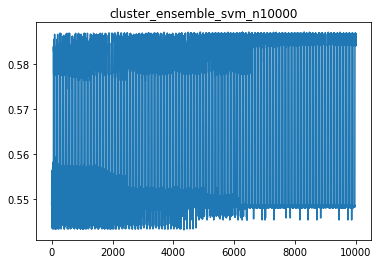

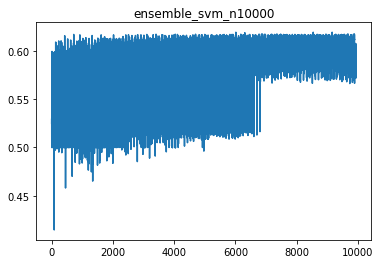

In [4]:
df = pd.read_csv("data/hpo/cluster_ensemble_svm_n10000_0228.csv")
df = df.sort_values(by=['Unnamed: 0'])
plt.plot(df['Unnamed: 0'], df['value'])
plt.title("cluster_ensemble_svm_n10000")
plt.show()

df = pd.read_csv("data/hpo/ensemble_svm_n10000.csv")
df = df.sort_values(by=['Unnamed: 0'])
plt.plot(df['Unnamed: 0'], df['value'])
plt.title("ensemble_svm_n10000")
plt.show()

In [11]:
consensusclass = np.genfromtxt("data/r_output/consensusClass_k10.csv")

In [45]:
output_data = cluster_sampler(x_cytosol, consensusclass, size=len(x_nucleus))
output_y = np.array(np.append(np.ones(len(output_data)), np.zeros(len(x_nucleus))))
output_data = np.append(output_data, x_nucleus, axis=0)
print(output_data.shape)
print(output_y.shape)
prob = svm_problem(output_y, output_data)
param = svm_parameter("-s 1 -t 0")
m = svm_train(prob, param)
p_label, p_acc, p_val = svm_predict(output_y, output_data, m)
print("roc:",metrics.roc_auc_score(output_y, p_label))

(377, 442)
(377,)
Accuracy = 79.3103% (299/377) (classification)
roc: 0.7931325640303968


In [14]:
x_cytosol = pd.read_csv("data/merge_data/k1234_PCPseDNCGa_TNCGa_PseDNC_cytosol.csv").to_numpy()
x_nucleus = pd.read_csv("data/merge_data/k1234_PCPseDNCGa_TNCGa_PseDNC_nucleus.csv").to_numpy()

In [96]:
class ensemble_svm():
    def __init__(self):
        self.model_array = None
    
    def train(self, data, label, parameter=""):
        model_array = []
        for d, l in zip(data, label):
            arr = np.arange(len(l))
            np.random.shuffle(arr)
            d = d[arr]
            l = l[arr]

            prob = svm_problem(l, d)
            param = svm_parameter(parameter)
            m = svm_train(prob, param)
            model_array.append(m)
        
        self.model_array = model_array
        
        return None
    def test(self, x, y):
        output = None
        for m in self.model_array:
            p_label, p_acc, p_val = svm_predict(y, x, m)
            if output is None:
                output = np.array([p_label])
            else:
                output = np.append(output, np.array([p_label]), axis=0)
        
        pred_y = []
        for o in output.T:
            u, c = np.unique(o, return_counts=True)
            pred_y.append(u[c == c.max()][0])
        
        return metrics.roc_auc_score(y, pred_y)
    
    def predict(self, x):
        output = None
        for m in self.model_array:
            p_label, p_acc, p_val = svm_predict([], x, m)
            if output is None:
                output = np.array([p_label])
            else:
                output = np.append(output, np.array([p_label]), axis=0)

        pred_y = []
        pred_y_score = []
        for o in output.T:
            u, c = np.unique(o, return_counts=True)
            pred_y.append(u[c == c.max()][0])
            pred_y_score.append(c.max() / sum(c))
        
        return pred_y, pred_y_score
    

In [18]:
def cluster_sampler(data, cluster_class, size=100):
    class_nums, class_counts = np.unique(cluster_class, return_counts=True)
    l = len(data)
    output_data = None
    for i in range(len(class_nums)):
        class_idx = np.arange(l)[cluster_class == class_nums[i]]
        n = math.ceil(size / l * len(class_idx))
        np.random.shuffle(class_idx)
        if output_data is None:
            output_data = data[class_idx[:n], :]
        else:
            output_data = np.append(output_data, data[class_idx[:n], :], axis=0)
    return output_data


# l = 5
# cluster_data = np.zeros((sum(range(1, l + 1)), 2))
# cluster_class = np.zeros(sum(range(1, l + 1)))
# for i in range(1, l + 1):
#     cluster_data[sum(range(i)):sum(range(i + 1))] = cluster_data[sum(range(i)):sum(range(i + 1))] + i
#     cluster_class[sum(range(i)):sum(range(i + 1))] = cluster_class[sum(range(i)):sum(range(i + 1))] + i

# print(cluster_data)
# print(cluster_class)

# cluster_sampler(cluster_data, cluster_class, size=5)

In [50]:
cv_x_cytosol, cv_consensuclass = ensemble_svm.CV(x_cytosol, consensusclass, 10)
cv_x_nucleus, _ = ensemble_svm.CV(x_nucleus, np.ones((len(x_nucleus))), 10)
print(x_cytosol.shape, consensusclass.shape)
print(cv_x_cytosol[0])
print(np.unique(consensusclass, return_counts=True)[1] / len(consensusclass))
print(np.unique(cv_consensuclass[0], return_counts=True)[1] / len(cv_consensuclass[0]))
# print(cv_consensuclass[0])

(2245, 442) (2245,)
[[0.31823124 0.24465386 0.28742298 ... 0.01312326 0.14710572 0.11397461]
 [0.29040404 0.25378788 0.27588384 ... 0.02159721 0.15349595 0.11863209]
 [0.29695886 0.2236136  0.29516995 ... 0.02169424 0.14125585 0.11626986]
 ...
 [0.23017241 0.32327586 0.24051724 ... 0.03133455 0.15252467 0.1205138 ]
 [0.24978467 0.30318691 0.22911283 ... 0.03868025 0.1525839  0.1230972 ]
 [0.21189024 0.33536585 0.27896341 ... 0.02775185 0.14873931 0.1230522 ]]
[0.07483296 0.10690423 0.13496659 0.13140312 0.11893096 0.10155902
 0.11314031 0.06414254 0.12739421 0.02672606]
[0.07272727 0.10909091 0.13636364 0.13181818 0.11818182 0.1
 0.11363636 0.06363636 0.12727273 0.02727273]


In [33]:
output_data = cluster_sampler(x_cytosol, consensusclass, size=len(x_nucleus))
print(output_data.shape)

output_y = np.array([np.append(np.ones(len(output_data)), np.zeros(len(x_nucleus)))])
print(output_y.shape)
output_data = np.append(output_data, x_nucleus, axis=0)
print(x_nucleus.shape)
print(output_data.shape)

(190, 442)
(1, 377)
(187, 442)
(377, 442)


TypeError: len() takes exactly one argument (0 given)

In [39]:
size = 10

ensemble_data = None
for i in range(size):
    output_data = cluster_sampler(x_cytosol, consensusclass, size=len(x_nucleus))
    
    output_y = np.array([np.append(np.ones(len(output_data)), np.zeros(len(x_nucleus)))])
    
    output_data = np.append(output_data, x_nucleus, axis=0)
    output_data = np.array([output_data])

    if ensemble_data is None:
        ensemble_data = output_data
    else:
        ensemble_data = np.append(ensemble_data, output_data, axis=0)
print(ensemble_data.shape)

(1000, 377, 442)


In [60]:
def cv_train_test(cv_x, cv_y):
    for j in range(len(cv_x)):
        train_x = None
        for i in range(len(cv_x)):
            if i == j :
                test_x = cv_x[i]
                test_y = cv_y[i]
            else:
                if train_x is None:
                    train_x = cv_x[i]
                    train_y = cv_y[i]
                else:
                    train_x = np.append(train_x, cv_x[i], axis=0)
                    train_y = np.append(train_y, cv_y[i], axis=0)
    return train_x, train_y, test_x, test_y

In [102]:
auroc_array = []

folder = 10
size = 3000

cv_x_cytosol, cv_consensuclass = svm_function.CV(x_cytosol, consensusclass, 10)
cv_x_nucleus, cv_y_nucleus = svm_function.CV(x_nucleus, np.zeros((len(x_nucleus))), 10)

for i in range(folder):
    train_cytosol_x, train_cytosol_consensuclass, test_cytosol_x, _ = cv_train_test(cv_x_cytosol, cv_consensuclass)
    train_nucleus_x, train_nucleus_y, test_nucleus_x, test_nucleus_y = cv_train_test(cv_x_nucleus, cv_y_nucleus)
    
    test_x = np.append(test_cytosol_x, test_nucleus_x, axis=0)
    test_y = np.append(np.ones(len(test_cytosol_x)), np.zeros(len(test_nucleus_x)), axis=0)
    
    # print(train_cytosol_x.shape)
    # print(train_nucleus_x.shape)
    # print(test_cytosol_x.shape)
    # print(test_nucleus_x.shape)
    # print(test_x.shape)
    # print(test_y.shape)
    
    ensemble_data_x = None
    ensemble_data_y = None
    for j in range(size):
        output_data = cluster_sampler(train_cytosol_x, train_cytosol_consensuclass, size=len(train_nucleus_x))
        
        output_y = np.array([np.append(np.ones(len(output_data)), np.zeros(len(train_nucleus_x)))])
        
        output_data = np.append(output_data, train_nucleus_x, axis=0)
        output_data = np.array([output_data])
        if ensemble_data_x is None:
            ensemble_data_x = output_data
            ensemble_data_y = output_y
        else:
            ensemble_data_x = np.append(ensemble_data_x, output_data, axis=0)
            ensemble_data_y = np.append(ensemble_data_y, output_y, axis=0)
    print(ensemble_data_x.shape)
    print(ensemble_data_y.shape)
    
    esvm = ensemble_svm()
    esvm.train(ensemble_data_x, ensemble_data_y, parameter="-t 0")
    pred_y, pred_y_score = esvm.predict(test_x)
    auroc = metrics.roc_auc_score(test_y, pred_y)
    # auroc = esvm.test(test_x, test_y)
    print("pred_y_score:", pred_y_score)
    print("auroc:", auroc)
    auroc_array.append(auroc)
    
    break

print("auroc:", auroc_array)
print("auroc avg:", sum(auroc_array) / len(auroc_array))

In [27]:
pd.DataFrame(data_x).to_csv('data/linear_features/linear/train/k3p10nor3.csv', index=False)

In [2]:
df = pd.read_csv("data/merge_data/k1234_PCPseDNCGa_TNCGa_PseDNC.csv")
y = np.load("data/data_y_train.npy")

In [18]:
df_n = df[y == 0]
print(len(df_n))
df_n.to_csv('data/merge_data/k1234_PCPseDNCGa_TNCGa_PseDNC_nucleus.csv', index=False)

187


In [8]:
l = np.load("data/k_mers/train/k4_datax.npy")
l = pd.DataFrame(l)
l.sort_values(by=[3], ascending=False)

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.028231,0.015331,0.036520,0.036271,0.042565,0.016328,0.022373,0.052038,0.007603,0.002431,...,0.000312,0.000312,0.000436,0.000312,0.000125,0.000062,0.000000,0.000000,0.000000,0.000000
1647,0.003778,0.010076,0.016373,0.027708,0.020151,0.007557,0.007557,0.012594,0.003778,0.005038,...,0.001259,0.001259,0.003778,0.001259,0.002519,0.002519,0.001259,0.001259,0.002519,0.002519
1104,0.000659,0.003955,0.003296,0.027027,0.020435,0.007251,0.004614,0.005933,0.000659,0.001318,...,0.000659,0.001318,0.000000,0.000000,0.002637,0.000000,0.001318,0.001318,0.001318,0.000659
2209,0.003448,0.003448,0.006897,0.024138,0.013793,0.006897,0.000000,0.010345,0.000000,0.006897,...,0.010345,0.003448,0.003448,0.000000,0.006897,0.000000,0.006897,0.000000,0.000000,0.003448
1992,0.000000,0.003711,0.016698,0.024119,0.007421,0.003711,0.001855,0.011132,0.003711,0.007421,...,0.000000,0.001855,0.001855,0.000000,0.001855,0.000000,0.000000,0.001855,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0.004425,0.006637,0.002212,0.000000,0.000000,0.002212,0.000000,0.004425,0.002212,0.000000,...,0.006637,0.000000,0.002212,0.004425,0.004425,0.000000,0.002212,0.002212,0.000000,0.002212
1877,0.001637,0.003273,0.001637,0.000000,0.001637,0.004910,0.001637,0.006547,0.000000,0.001637,...,0.006547,0.003273,0.000000,0.000000,0.004910,0.006547,0.003273,0.001637,0.001637,0.000000
2243,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.017544,0.000000,0.000000,0.017544,0.000000,0.017544,0.017544,0.000000
2240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012821,0.000000,0.000000,0.012821,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012821,0.000000,0.000000,0.000000


In [23]:
from Function.ensemble_svm import cv_msvm_score

files_path = ["data/k_mers/train/k1234_datax.npy",
              "data/Pse_in_One2/DNA/train/cdhit80_data_seq_loc75_train_PCPseDNCGeneral_all_index.csv",
              "data/Pse_in_One2/DNA/train/cdhit80_data_seq_loc75_train_PCPseTNCGeneral_all_index.csv",
              "data/Pse_in_One2/DNA/train/cdhit80_data_seq_loc75_train_PseDNC.csv"]

data_y = np.load("data/data_y_train.npy")

log_array = []
start_time = time.time()
data_x = None
for file_name in files_path:
    print(file_name)
    file_time = time.time()
    if file_name.split(".")[-1] == "csv":
        tump = np.genfromtxt(file_name, delimiter=',')
    if file_name.split(".")[-1] == "npy":
        tump = np.load(file_name)
        # data_x = data_x.reshape(data_x.shape[0],-1)
    data_x = tump if data_x is None else np.c_[data_x, tump]
print(data_x.shape)
# score_array = cv_msvm_score(data_x, data_y, 10, size=500, parameter="")
# cv_msvm_auroc = sum(score_array) / len(score_array)
# print(cv_msvm_auroc)

data/k_mers/train/k1234_datax.npy
data/Pse_in_One2/DNA/train/cdhit80_data_seq_loc75_train_PCPseDNCGeneral_all_index.csv
data/Pse_in_One2/DNA/train/cdhit80_data_seq_loc75_train_PCPseTNCGeneral_all_index.csv
data/Pse_in_One2/DNA/train/cdhit80_data_seq_loc75_train_PseDNC.csv
(2432, 442)


In [45]:
from sklearn.cluster import KMeans

from consensusClustering import ConsensusCluster
comb = ConsensusCluster(cluster=KMeans, L=1, K=15, H=10)
comb.fit(data_x)
temp = comb.predict()

In [15]:
# data_x = np.load("data/linear_features/linear/k3p10nor3.npy")
# data_x = data_x.reshape(data_x.shape[0],-1)
data_x = np.genfromtxt("data/Pse_in_One2/DNA/cdhit80_data_seq_loc75_PCPseDNCGeneral_all_index.csv", delimiter=',')
data_y = np.load("data/linear_features/data_y.npy")

comb_num = 2

for i in range(2, comb_num + 1):
    combins = [c for c in combinations(range(data_x.shape[1]), i)]
    for c in combins:
        x_train, x_test, y_train, y_test = train_test_split(data_x[:, c], data_y, test_size=0.20, shuffle=True, random_state=12)
        
        macro = cv_msvm_score(data_x[:, c], data_y, 10)
        print(macro)
        break
    break

Accuracy = 36.6337% (111/303) (classification)
Accuracy = 70.9571% (215/303) (classification)
Accuracy = 54.7855% (166/303) (classification)
Accuracy = 22.4422% (68/303) (classification)
Accuracy = 25.7426% (78/303) (classification)
Accuracy = 26.0726% (79/303) (classification)
Accuracy = 63.6964% (193/303) (classification)
Accuracy = 68.3168% (207/303) (classification)
Accuracy = 24.0924% (73/303) (classification)
Accuracy = 70.9571% (215/303) (classification)
Accuracy = 11.2211% (34/303) (classification)
Accuracy = 7.26073% (22/303) (classification)
Accuracy = 36.9637% (112/303) (classification)
Accuracy = 24.0924% (73/303) (classification)
Accuracy = 56.7657% (172/303) (classification)
Accuracy = 66.0066% (200/303) (classification)
Accuracy = 29.703% (90/303) (classification)
Accuracy = 7.92079% (24/303) (classification)
Accuracy = 19.1419% (58/303) (classification)
Accuracy = 40.9241% (124/303) (classification)
Accuracy = 27.0627% (82/303) (classification)
Accuracy = 33.6634% (102/

In [44]:
merge_df = None
for i in range(1, 6):
    if i != 2:
        print(i)    
        l = np.load("data/log/pseinone_cv_msvm_f10s"+str(i)+"00.npy")
        df = pd.DataFrame(l, columns=["file name", "Feature num", "time", "s" + str(i) + "00"]).drop(['time'], axis=1)
        if merge_df is None:
            merge_df = df
        else:
            merge_df = merge_df.merge(df, how="inner", on=["file name", "Feature num"])
        print(merge_df)

1
                                        file name Feature num  \
0             cdhit80_data_seq_loc75_aucg_DAC.csv          12   
1             cdhit80_data_seq_loc75_aucg_DCC.csv          60   
2             cdhit80_data_seq_loc75_aucg_MAC.csv           6   
3           cdhit80_data_seq_loc75_aucg_NMBAC.csv           6   
4        cdhit80_data_seq_loc75_aucg_PCPseDNC.csv          18   
5        cdhit80_data_seq_loc75_aucg_SCPseDNC.csv          28   
6   cdhit80_data_seq_loc75_aucg_mismatch_k3m2.csv          64   
7   cdhit80_data_seq_loc75_aucg_mismatch_k3m1.csv          64   
8   cdhit80_data_seq_loc75_aucg_mismatch_k2m1.csv          16   
9   cdhit80_data_seq_loc75_aucg_mismatch_k4m1.csv         256   
10  cdhit80_data_seq_loc75_aucg_mismatch_k4m2.csv         256   
11  cdhit80_data_seq_loc75_aucg_mismatch_k4m3.csv         256   

                  s100  
0   0.5128660984767431  
1   0.5072936004412559  
2   0.5063051040027182  
3   0.5278744563234673  
4   0.5276809130144483  
5 

In [14]:
import math

from sklearn import metrics

from libsvm.svmutil import svm_problem
from libsvm.svmutil import svm_parameter
from libsvm.svmutil import svm_train
from libsvm.svmutil import svm_predict

class multi_SVM():
    def __init__(self, class_weight='None'):
        self.class_weight = class_weight
        self.model_array = None
    
    def train(self, x, y, size=1, parameter=""):
        if self.class_weight == 'balanced':
            data = None
            label = None
            for i in range(size):
                d, l = self.balanced_data(x, y)
                if data is None:
                    data = d
                    label = l
                else:
                    data = np.append(data, d, axis=0)
                    label = np.append(label, l, axis=0)
        
        model_array = []
        for d, l in zip(data, label):
            arr = np.arange(len(l))
            np.random.shuffle(arr)
            d = d[arr]
            l = l[arr]

            prob = svm_problem(l, d)
            param = svm_parameter(parameter)
            m = svm_train(prob, param)
            model_array.append(m)
        
        self.model_array = model_array
        
        return None
    
    def test(self, x, y):
        output = None
        for m in self.model_array:
            p_label, p_acc, p_val = svm_predict(y, x, m)
            if output is None:
                output = np.array([p_label])
            else:
                output = np.append(output, np.array([p_label]), axis=0)
        
        pred_y = []
        for o in output.T:
            u, c = np.unique(o, return_counts=True)
            pred_y.append(u[c == c.max()][0])
        
        return metrics.roc_auc_score(y, pred_y)
    
    def predict(self, x):
        output = None
        for m in self.model_array:
            p_label, p_acc, p_val = svm_predict([], x, m)
            if output is None:
                output = np.array([p_label])
            else:
                output = np.append(output, np.array([p_label]), axis=0)
        
        pred_y = []
        for o in output.T:
            u, c = np.unique(o, return_counts=True)
            pred_y.append(u[c == c.max()][0])
        
        return pred_y
    
    def balanced_data(self, x, y):
        unique, count = np.unique(y, return_counts=True)
        min_count = min(count)
        big_batch = math.ceil(max(count) / min_count)
        min_u = np.where(count == min_count, unique, -1)
        
        data = None
        label = None
        for u in unique:
            u_data = None
            if not u in min_u:
                while u_data is None or len(u_data) != big_batch * min_count:
                    x_u = x[y == u]
                    np.random.shuffle(x_u)
                    mod = len(x_u) % min_count
                    if mod != 0:
                        arr = np.arange(len(x_u) - mod)
                        np.random.shuffle(arr)
                        x_u = np.append(x_u, x_u[arr[mod - min_count:]], axis=0)
                    if u_data is None:
                        u_data = x_u
                    else:
                        u_data = np.append(u_data, x_u[:(big_batch * min_count) - len(u_data)], axis=0)
                u_data = np.array(np.split(u_data, big_batch))
            else:
                x_u = x[y == u]
                x_u = np.expand_dims(x_u, axis=0)
                u_data = np.repeat(x_u, big_batch, axis=0)

            if data is None:
                data = u_data
                label = np.full((big_batch, min_count), u)
            else:
                data = np.append(data, u_data, axis=1)  
                label = np.append(label, np.full((big_batch, min_count), u), axis=1)

        return data, label

def CV(x, y, folder):
    unique, count = np.unique(y, return_counts=True)
    cv_x = []
    cv_y = []
    for u in unique:
        u_x = x[y == u]
        u_y = y[y == u]
        arr = np.arange(len(u_x))
        np.random.shuffle(arr)
        u_x = u_x[arr]
        u_y = u_y[arr]
        
        linspace = np.linspace(0, len(u_x), folder + 1, dtype=int)
        
        for i in range(folder):
            if unique[0] == u:
                cv_x.append(u_x[linspace[i]:linspace[i+1]])
                cv_y.append(u_y[linspace[i]:linspace[i+1]])
            else:
                cv_x[i] = np.append(cv_x[i], u_x[linspace[i]:linspace[i+1]], axis=0)
                cv_y[i] = np.append(cv_y[i], u_y[linspace[i]:linspace[i+1]], axis=0)
    return cv_x, cv_y

def cv_msvm_score(x, y, folder, size=15, parameter=""):
    cv_x, cv_y = CV(x, y, folder)
    score_array = []
    for j in range(len(cv_x)):
        train_x = None
        for i in range(len(cv_x)):
            if i == j :
                test_x = cv_x[i]
                test_y = cv_y[i]
            else:
                if train_x is None:
                    train_x = cv_x[i]
                    train_y = cv_y[i]
                else:
                    train_x = np.append(train_x, cv_x[i], axis=0)
                    train_y = np.append(train_y, cv_y[i], axis=0)
        msvm = multi_SVM(class_weight='balanced')
        msvm.train(train_x, train_y, size=size, parameter=parameter)
        score_array.append(msvm.test(test_x, test_y))
    return score_array


In [3]:
data_x = np.load("data/linear_features/linear/k3p10nor3.npy")
data_x = data_x.reshape(data_x.shape[0],-1)
data_y = np.load("data/linear_features/data_y.npy")
macro_np = None
for i in range(data_x.shape[1]):
    # x_train, x_test, y_train, y_test = train_test_split(data_x[:, i, :], data_y, test_size=0.20, shuffle=True, random_state=12)
    
    # prob = svm_problem(y_train, x_train)
    # param = svm_parameter('')
    # m = svm_train(prob, param)
    # p_label, p_acc, p_val = svm_predict(y_test, x_test, m)
    # macro = f1_score(p_label, y_test, average='macro')
    
    # msvm = multi_SVM(class_weight='balanced')
    # msvm.train(x_train, y_train, size=15)
    # macro = msvm.test(x_test, y_test)
    
    macro = cv_msvm_score(data_x[:, i, :], data_y, 10)
    
    print("macro:", macro)
    temp = np.array([[i, macro]])
    if macro_np is None:
        macro_np = temp
    else:
        macro_np = np.append(macro_np, temp, axis=0)
print(macro_np)

Accuracy = 12.9934% (79/608) (classification)
Accuracy = 12.9934% (79/608) (classification)
Accuracy = 12.9934% (79/608) (classification)
Accuracy = 12.9934% (79/608) (classification)
Accuracy = 12.9934% (79/608) (classification)
Accuracy = 12.9934% (79/608) (classification)
Accuracy = 12.9934% (79/608) (classification)
Accuracy = 12.9934% (79/608) (classification)
Accuracy = 12.9934% (79/608) (classification)
Accuracy = 12.9934% (79/608) (classification)
Accuracy = 12.9934% (79/608) (classification)
Accuracy = 12.9934% (79/608) (classification)
Accuracy = 12.9934% (79/608) (classification)
Accuracy = 12.9934% (79/608) (classification)
Accuracy = 12.9934% (79/608) (classification)
Accuracy = 12.9934% (79/608) (classification)
Accuracy = 12.9934% (79/608) (classification)
Accuracy = 12.9934% (79/608) (classification)
Accuracy = 12.9934% (79/608) (classification)
Accuracy = 12.9934% (79/608) (classification)
Accuracy = 12.9934% (79/608) (classification)
Accuracy = 12.9934% (79/608) (clas

In [48]:
data_x = np.load("data/linear_features/linear/k4p10nor3.npy")
data_x = data_x.reshape(data_x.shape[0],-1)
data_x = np.c_[ data_x, np.load("data/linear_features/data_len.npy") ] 
data_y = np.load("data/linear_features/data_y.npy")

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.20, shuffle=True, random_state=12)
# print("SVC")
# clf = svm.SVC()
# clf.fit(x_train, y_train)
# y_pred = clf.predict(x_test)
# print("macro:", f1_score(y_test, y_pred, average='macro'))

# print("SVM")
# prob = svm_problem(y_train, x_train)
# param = svm_parameter('')
# m = svm_train(prob, param)
# p_label, p_acc, p_val = svm_predict(y_test, x_test, m)
# print("macro:", f1_score(p_label, y_test, average='macro'))

print("mSVM")
msvm = multi_SVM(class_weight='balanced')
msvm.train(x_train, y_train, size=15)
msvm.test(x_test, y_test)

mSVM


In [17]:
x = np.load("data/linear_features/score_history/dle_point_score_history_1639120891.2122715.npy")
# x = np.around(x, decimals=2)
# print(x.shape)
# print(x[x[:, 3].argsort()][::-1][:10])
x = x[x[:, -1].argsort()][::-1]
x = pd.DataFrame(x, columns=["k", "power", "nor", "num", "features", "acc", "f1 macro"])
x.head(20)

,k,power,nor,num,features,acc,f1 macro
0,4.0,8.0,3.0,10.0,2560.0,0.878289,0.589354
1,4.0,8.0,3.0,8.0,2048.0,0.876645,0.579890
2,4.0,10.0,3.0,8.0,2048.0,0.868421,0.571936
3,4.0,10.0,3.0,10.0,2560.0,0.868421,0.571936
4,4.0,10.0,3.0,5.0,1280.0,0.866776,0.562687
5,4.0,8.0,3.0,3.0,768.0,0.837171,0.558629
6,4.0,8.0,3.0,5.0,1280.0,0.866776,0.554651
7,3.0,8.0,3.0,10.0,640.0,0.763158,0.550877
8,4.0,10.0,3.0,3.0,768.0,0.832237,0.548449
9,3.0,8.0,3.0,8.0,512.0,0.746711,0.535473


In [8]:
df = pd.read_csv("data/linear_features/cdhit80_data_seq_loc75_train.csv")
df.head(3)

,Unnamed: 0,Refseq_ID,Gene_ID,Sequence,loc
0,8,NM_002457.4,NCBI:4583,CAACCCACACCGCCCCTGCCAGCCACCATGGGGCTGCCACTAGCCC...,Cytosolic
1,12,NR_073405.1,NCBI:441733,AGCACGCTGGCGGCTACCAAGCTGGAGGAGGCGGCGGGCGCGAGAC...,Cytosolic
2,13,NR_027418.1,NCBI:100499466,CTCGCCCCCCCGGAGCCGACAAATGGCCGCGGCGGCCTCAGGTCCG...,Cytosolic


In [11]:
np.save("data/linear_features/data_len.npy", np.array(df['Sequence'].apply(len)))

In [33]:
df = pd.read_csv("data/lncATLAS/2021-11-25_lncATLAS_all_data.csv")

In [61]:
nc_df = df[df["Coding Type"] == 'nc']

# nc_df = nc_df[nc_df["Data Type"].isin(["cytosol", "nucleus"])]
nc_df = nc_df[(nc_df["Value"].notna()) & (nc_df["Value"] > 0)]
c_df = nc_df[nc_df["Data Type"] == "cytosol"]
n_df = nc_df[nc_df["Data Type"] == "nucleus"]

In [71]:
cell_line = nc_df["Data Source"].unique()
print(nc_df.head(4))
# c_df = c_df[c_df["Value"] > 0.1]
# n_df = n_df[n_df["Value"] > 0.1]

             ENSEMBL ID Data Source Data Type    Value  Gene Name Coding Type  \
107011  ENSG00000082929       MCF.7      cell  0.33500  LINC01587          nc   
107012  ENSG00000082929       MCF.7   cytosol  0.96500  LINC01587          nc   
107013  ENSG00000082929       MCF.7   nucleus  0.41000  LINC01587          nc   
107014  ENSG00000082929       MCF.7    ratio2  1.23491  LINC01587          nc   

       Biotype  
107011      nc  
107012      nc  
107013      nc  
107014      nc  


In [76]:
print(len(nc_df))
print(len(c_df))
print(len(n_df))

160119
39696
46517


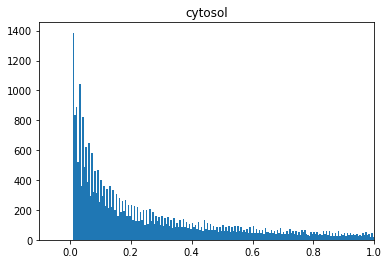

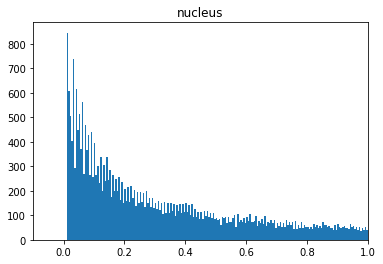

In [67]:
v_np = np.array(c_df["Value"])
# plt.hist(v_np, bins='auto')
plt.hist(v_np, bins=np.sort(np.array(c_df["Value"].unique())))
plt.xlim(-0.1, 1)
plt.title("cytosol")
plt.show()

v_np = np.array(n_df["Value"])
# plt.hist(v_np, bins='auto')
plt.hist(v_np, bins=np.sort(np.array(n_df["Value"].unique())))
plt.xlim(-0.1, 1)
plt.title("nucleus")
plt.show()

In [8]:
cnrci = df[df["Data Type"] == "CNRCI"]
cnrci = cnrci[cnrci["Value"].notna()]
cnrci = cnrci[cnrci["Coding Type"] == 'nc']
ensembl_id = cnrci["ENSEMBL ID"].unique()

In [9]:
cnrci#["Biotype"].unique()

,ENSEMBL ID,Data Source,Data Type,Value,Gene Name,Coding Type,Biotype
31474,ENSG00000082929,MCF.7,CNRCI,1.23491,LINC01587,nc,nc
39740,ENSG00000093100,A549,CNRCI,-3.15798,XXbac-B461K10.4,nc,nc
39741,ENSG00000093100,GM12878,CNRCI,-2.00351,XXbac-B461K10.4,nc,nc
39742,ENSG00000093100,H1.hESC,CNRCI,-2.21820,XXbac-B461K10.4,nc,nc
39743,ENSG00000093100,HeLa.S3,CNRCI,-2.05661,XXbac-B461K10.4,nc,nc
...,...,...,...,...,...,...,...
714484,ENSG00000283122,HepG2,CNRCI,-2.58496,HYMAI,nc,nc
714485,ENSG00000283122,HT1080,CNRCI,-1.48543,HYMAI,nc,nc
714487,ENSG00000283122,IMR.90,CNRCI,-3.30581,HYMAI,nc,nc
714494,ENSG00000283122,MCF.7,CNRCI,-3.54432,HYMAI,nc,nc


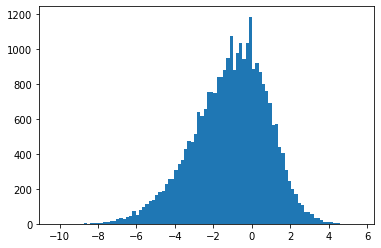

In [11]:
v_np = np.array(cnrci["Value"])
plt.hist(v_np, bins='auto')
# plt.xlim(-0.5, 10)
plt.show()

In [ ]:
variance = []
for eidx in ensembl_id:
    if len(cnrci[cnrci["ENSEMBL ID"] == eidx]["Value"]) > 1:
        variance.append(statistics.variance(cnrci[cnrci["ENSEMBL ID"] == eidx]["Value"]))

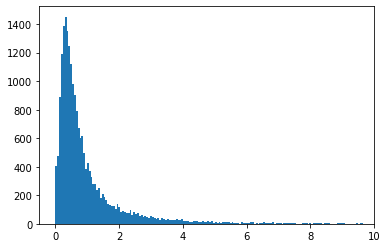

In [59]:
v_np = np.array(variance)
plt.hist(v_np, bins='auto')
plt.xlim(-0.5, 10)
plt.show()

In [21]:
nc_count = pd.DataFrame([], columns=["id", "N", "C"])
for eidx in ensembl_id:
    temp = pd.DataFrame([[eidx, len(cnrci[(cnrci["ENSEMBL ID"] == eidx) & (cnrci["Value"] > 0)]) , len(cnrci[(cnrci["ENSEMBL ID"] == eidx) & (cnrci["Value"] < 0)])]], columns=["id", "N", "C"])
    nc_count = nc_count.append(temp)
print(nc_count.head(10))

                id  N   C
0  ENSG00000082929  1   0
0  ENSG00000093100  0  15
0  ENSG00000099869  2   0
0  ENSG00000100181  1   4
0  ENSG00000116652  1   6
0  ENSG00000116883  0  10
0  ENSG00000117242  7   7
0  ENSG00000120055  4   1
0  ENSG00000120664  1   2
0  ENSG00000124915  0   2


In [30]:
nc_count["SUM"] = nc_count["N"] + nc_count["C"]
nc_count = nc_count[nc_count["SUM"] > 0]
nc_count["N/SUM"] = nc_count["N"] * (1 / nc_count["SUM"])
print(nc_count.head(5))

                id  N   C SUM     N/SUM
0  ENSG00000082929  1   0   1         1
0  ENSG00000093100  0  15  15         0
0  ENSG00000099869  2   0   2         1
0  ENSG00000100181  1   4   5       0.2
0  ENSG00000116652  1   6   7  0.142857


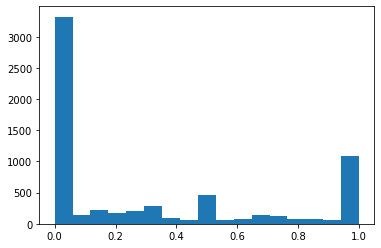

In [32]:
v_np = np.array(nc_count["N/SUM"])
plt.hist(v_np, bins='auto')
# plt.xlim(-0.5, 10)
plt.show()

In [16]:
nc_count = nc_count.groupby(by=["N", "C"]).count().reset_index()

In [17]:
h_m = np.zeros((15,15))

for n in range(15):
    for c in range(15):
        if len(nc_count[(nc_count["N"] == n) & (nc_count["C"] == c)]):
            h_m[n, c] = int(list(nc_count[(nc_count["N"] == n) & (nc_count["C"] == c)]["id"])[0])

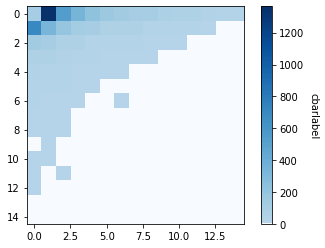

In [20]:
fig, ax = plt.subplots()
bottom = plt.cm.get_cmap('Blues', 128)
newcolors = np.vstack((bottom(0),
                       bottom(np.linspace(0.3, 1, 128))))
newcmp = matplotlib.colors.ListedColormap(newcolors, name='OrangeBlue')
im = ax.imshow(h_m, cmap=newcmp)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("cbarlabel", rotation=-90, va="bottom")
plt.show()

In [43]:
score_history = np.load("data/linear_features/score_history/score_history.npy")
# score_history = score_history[score_history[:, 3].argsort()]
score_history = pd.DataFrame(score_history, columns=["k", "power", "normalization", "acc", "f1_score_macro"])
print(score_history)
# score_history.to_csv("data/linear_features/score_history/dle_point_score_history_1123.csv", index=False)

      0     1    2         3
0   1.0   4.0  0.0  0.552361
1   1.0   4.0  1.0  0.577002
2   1.0   4.0  2.0  0.535934
3   1.0   4.0  3.0  0.542094
4   1.0   6.0  0.0  0.546201
..  ...   ...  ...       ...
59  4.0   8.0  3.0  0.924025
60  4.0  10.0  0.0  0.683778
61  4.0  10.0  1.0  0.882957
62  4.0  10.0  2.0  0.850103
63  4.0  10.0  3.0  0.928131

[64 rows x 4 columns]


In [2]:
df = pd.read_csv("data/linear_features/cdhit80_data_seq_loc75.csv")

In [3]:
data_x = df["Sequence"]
data_y = np.where(df["loc"].to_numpy() == "Cytosolic", 1, 0)

In [5]:
np.save("data/linear_features/data_y.npy", data_y)

In [4]:
x = np.load("data/linear_features/cdhit80_loc75_k1_power8_nor3.npy")
print(x.shape)

(2432, 37)


In [ ]:
x = None
for i in range(64):
    if x is None:
        x = np.array([data_x[:, i*10 + 4]]).T
        # x = np.array([data_x[:, i*10], data_x[:, i*10 + 9]]).T
        # x = np.array([np.average(data_x[:, i*10:(i+1)*10], axis=1)]).T
    else:
        x = np.append(x, np.array([data_x[:, i*10 + 4]]).T, axis=1)
        # x = np.append(x, np.array([data_x[:, i*10], data_x[:, i*10 + 9]]).T, axis=1)
        # x = np.append(x, np.array([np.average(data_x[:, i*10:(i+1)*10], axis=1)]).T, axis=1)
print(x.shape)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, data_y, test_size=0.20, shuffle=True, random_state=12)

In [6]:
print(np.unique(data_y, return_counts=True))
print(np.unique(y_train, return_counts=True))

(array([0, 1]), array([ 187, 2245]))
(array([0, 1]), array([ 147, 1798]))


In [6]:
clf = svm.SVC(kernel='linear', class_weight='balanced')
scores = cross_val_score(clf, x, data_y, cv=5, scoring='f1_macro')

In [7]:
print("score:", scores)
y_pred = clf.predict(x_test)
print("macro:", f1_score(y_test, y_pred, average='macro'))

score: [0.85343261 0.80478554 0.85592885 0.83167797 0.72709271]


NotFittedError: This SVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [7]:
clf = svm.SVC(kernel='linear', C=1, class_weight='balanced').fit(x_train, y_train)
            
score = clf.score(x_test, y_test)
print("score:", score)
y_pred = clf.predict(x_test)
print("macro:", f1_score(y_test, y_pred, average='macro'))

score: 0.971252566735113
macro: 0.9175773694390716


In [8]:
print(np.unique(y_test, return_counts=True))
print(x_test[y_test == 1].shape)
print(x_test[y_test == 0].shape)
print(clf.score(x_test[y_test == 0], y_test[y_test == 0]))
print(clf.score(x_test[y_test == 1], y_test[y_test == 1]))
y_pred = clf.predict(x_test)
print("macro:", f1_score(y_test, y_pred, average='macro'))

(array([0, 1]), array([ 40, 447]))
(447, 37)
(40, 37)
1.0
0.9686800894854586
macro: 0.9175773694390716


In [10]:
import pickle
with open('data/k_mers/model/k1p8n3_svm.pickle', 'wb') as f:
    pickle.dump(clf, f)

In [11]:
with open('data/k_mers/model/k1p8n3_svm.pickle', 'rb') as f:
    clf2 = pickle.load(f)
y_pred = clf2.predict(x_test)
print("macro:", f1_score(y_test, y_pred, average='macro'))

macro: 0.9175773694390716


In [39]:
import time
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import datasets
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn import metrics

from libsvm.svmutil import *
from imblearn.over_sampling import SMOTE

k_array = [1]
nor_array = [2]
num_array = [1]
k_array = [1, 2, 3, 4]
nor_array = [2, 3]
num_array = [1, 2, 3, 5, 8, 10]

data_y = np.load("data/linear_features/data_y.npy")

score_history = None
start_time = time.time()
for k in k_array:
    for nor in nor_array:
        for num in num_array:
            print("k=%s, nor=%s, num=%s" % (k, nor, num))
            
            data_x = np.load("data/linear_features/point/k" + str(k) + "nor" + str(nor) + "n" + str(num) + ".npy")
            data_x = data_x.reshape(data_x.shape[0],-1)
            print(data_x.shape)
            
            x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.20, shuffle=True, random_state=12)
            
            prob = svm_problem(y_train, x_train, isKernel=True)
            param = svm_parameter('-t 0 -w0 1798 -w1 147')
            m = svm_train(prob, param)
            p_label, p_acc, p_val = svm_predict(y_test, x_test, m)
            (score, MSE, SCC) = evaluations(y_test, p_label)
            macro = f1_score(y_test, p_label, average='macro')
            print("score:", score)
            print("macro:", macro)
            print(metrics.confusion_matrix(y_test, p_label) / len(y_test))
            # if macro >= 0.6:
            #     with open("data/linear_features/model/k" + str(k) + "nor" + str(nor) + "n" + str(num) + "point_1122_" + str(start_time) + ".pickle", 'wb') as f:
            #         pickle.dump(clf, f)
            
            if score_history is None:
                score_history = np.array([[k, nor, num, data_x.shape[1], score, macro]])
            else:
                score_history = np.append(score_history, [[k, nor, num, data_x.shape[1], score, macro]], axis=0)
print(score_history)

k=1, nor=2, num=1
(2432, 4)
Accuracy = 41.0678% (200/487) (classification)
score: 41.067761806981515
macro: 0.3470721509821783
[[0.04928131 0.03285421]
 [0.55646817 0.3613963 ]]
k=1, nor=2, num=2
(2432, 8)
Accuracy = 66.7351% (325/487) (classification)
score: 66.73511293634496
macro: 0.44798488664987407
[[0.01848049 0.06365503]
 [0.26899384 0.64887064]]
k=1, nor=2, num=3
(2432, 12)
Accuracy = 29.7741% (145/487) (classification)
score: 29.774127310061605
macro: 0.2699610772143909
[[0.0513347  0.03080082]
 [0.67145791 0.24640657]]
k=1, nor=2, num=5
(2432, 20)
Accuracy = 19.3018% (94/487) (classification)
score: 19.301848049281315
macro: 0.1907117758242316
[[0.0698152  0.01232033]
 [0.79466119 0.12320329]]
k=1, nor=2, num=8
(2432, 32)
Accuracy = 13.1417% (64/487) (classification)
score: 13.141683778234087
macro: 0.13105045366538856
[[0.07597536 0.00616016]
 [0.862423   0.05544148]]
k=1, nor=2, num=10
(2432, 40)
Accuracy = 9.65092% (47/487) (classification)
score: 9.650924024640657
macro: 

In [38]:
from libsvm.svmutil import *
from imblearn.over_sampling import SMOTE

print(np.unique(y_train, return_counts=True))

# sm = SMOTE(random_state=42)
# x_res, y_res = sm.fit_resample(x_train, y_train)
# prob = svm_problem(y_res, x_res, isKernel=True)
prob = svm_problem(y_train, x_train, isKernel=True)
param = svm_parameter('-t 0 -w0 1798 -w1 147')
m = svm_train(prob, param)
p_label, p_acc, p_val = svm_predict(y_test, x_test, m)
print(f1_score(y_test, p_label, average='macro'))

(array([0, 1]), array([ 147, 1798]))
Accuracy = 41.0678% (200/487) (classification)
0.3470721509821783


In [11]:
from libsvm.svmutil import *
from imblearn.over_sampling import SMOTE

prob = svm_problem(data_y, x, isKernel=True)
param = svm_parameter('-v 10')
svm_train(prob, param)

Cross Validation Accuracy = 92.3109%


92.3108552631579

In [43]:
f_array = np.load("data/linear_features/k2_power10.npy")
vocab = np.load("data/linear_features/k2_vocab.npy")
print(f_array.shape)

(2432, 16, 11)


In [44]:
token_out = 10
data = []
for f in f_array:
    f_p = np.array([])
    for z in f:
        p = np.poly1d(z)
        f_p = np.append(f_p, p(np.linspace(0, 1.0, num=token_out)))
    data.append(f_p)
x = np.array(data)
print(x.shape)

(2432, 160)


In [52]:
k = 1
nor_str = "_norL"
data_df = pd.read_csv("data/linear_features/old/cdhit80_k" + str(k) + "_linear10" + nor_str + "_loc75.csv")
vocab = np.load("data/linear_features/old/cdhit80_k" + str(k) + "_vocab.npy")

In [31]:
col = data_df.columns
data_x = data_df[col[:-2]].to_numpy()
data_y = data_df[col[-1]].to_numpy()
data_y = np.where(data_y == "Cytosolic", 1, 0)

idx = np.arange(len(data_y))
np.random.shuffle(idx)
x_train = data_x[idx[:int(len(idx) * 0.8)]]
y_train = data_y[idx[:int(len(idx) * 0.8)]]
x_test = data_x[idx[int(len(idx) * 0.8):]]
y_test = data_y[idx[int(len(idx) * 0.8):]]
print(x_train.shape)
y_weight = np.unique(y_train, return_counts=True)[1]
print(y_weight)
print(x_test.shape)
print(np.unique(y_test, return_counts=True))

(1945, 176)
[ 142 1803]
(487, 176)
(array([0, 1]), array([ 38, 449]))


In [4]:
prob = svm_problem(y_train, x_train, isKernel=True)
param = svm_parameter('-t 1 -c 4 -w0 ' + str(y_weight[1]) + ' -w1 ' + str(y_weight[0]))
m = svm_train(prob, param)
p_label, p_acc, p_val = svm_predict(y_test, x_test, m)

NameError: name 'svm_problem' is not defined

In [32]:
preformance_vacab = []

for i in range(len(vocab)):
    x_v_train = x_train[:, 11*i:11*i+11]
    x_v_test = x_test[:, 11*i:11*i+11]
    # x_v_train = np.append(x_train[:, 11*i:11*i+11], np.array([x_train[:, -1]]).T, axis=1)
    # x_v_test = np.append(x_test[:, 11*i:11*i+11], np.array([x_test[:, -1]]).T, axis=1)
    # prob = svm_problem(y_train, x_train[:, 11*i:11*i+11], isKernel=True)
    # param = svm_parameter('-t 1 -c 10 -w0 ' + str(y_weight[1]) + ' -w1 ' + str(y_weight[0]))
    # m = svm_train(prob, param)
    # p_label, p_acc, p_val = svm_predict(y_test, x_test[:, 11*i:11*i+11], m)
    # f1 = f1_score(y_test, p_label, average=None)
    # print(f1)
    clf = svm.SVC(kernel='rbf', C=1, class_weight='balanced').fit(x_v_train, y_train)
    y_pred = clf.predict(x_v_test)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average=None)
    preformance_vacab.append([i, f1_macro, f1[0], f1[1]])
    # print("score:", clf.score(x_test[:, 11*i:11*i+11], y_test))
preformance_vacab = np.array(preformance_vacab)
preformance_vacab = preformance_vacab[np.argsort(preformance_vacab[:, 1])]

In [33]:
preformance_vacab[-5:]

array([[12.        ,  0.44893685,  0.17283951,  0.7250342 ],
       [11.        ,  0.44952274,  0.16806723,  0.73097826],
       [13.        ,  0.45393055,  0.15454545,  0.75331565],
       [ 1.        ,  0.48629033,  0.1761658 ,  0.79641485],
       [ 7.        ,  0.50354369,  0.16      ,  0.84708738]])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.20, shuffle=True, random_state=12)

In [22]:
value_counts = train_df["loc"].value_counts()

for i in range(len(value_counts)):
    while (max(value_counts) - value_counts[i]) / max(value_counts) > .1:
        print((max(value_counts) - value_counts[i]) / max(value_counts))
        train_df = train_df.append(train_df[train_df["loc"] == value_counts.index[i]][:(max(value_counts) - value_counts[i])])
        value_counts = train_df["loc"].value_counts()

print(value_counts)


0.9194444444444444
0.8388888888888889
0.6777777777777778
0.35555555555555557
Cytosolic    1800
Nucleus      1800
Name: loc, dtype: int64


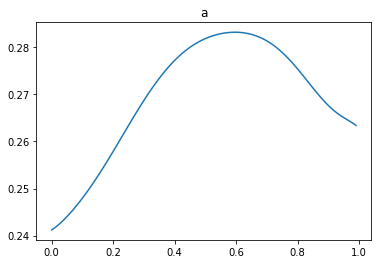

In [55]:
col = data_df.columns
cyt_df = data_df[data_df["loc"] == "Cytosolic"]
cyt_l = cyt_df.loc[:, ["len"]].to_numpy()
cyt_l = np.ones_like(cyt_l)

len_v = int((len(col)-2) / 11)

for i in range(len_v):
    for z, l in zip(cyt_df.loc[:, col[11*i:11*i+11]].to_numpy(), cyt_l):
        t = np.arange(0, l, 0.01)
        p = np.poly1d(z)

        plt.plot(t, p(t), alpha=1, color="#1f77b4")
        break
        
    # plt.xlim(0, np.average(cyt_l))
    plt.title(vocab[i])
    plt.show()
    break


[0.30459667 0.30563531 0.30480713 0.30405863 0.30499612 0.30685001
 0.30871487 0.3108631  0.31331082 0.31590429]


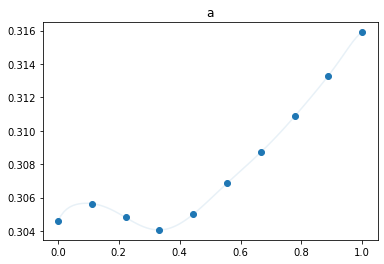

In [59]:
nuc_df = data_df[data_df["loc"] == "Nucleus"]
nuc_l = nuc_df.loc[:, ["len"]].to_numpy()
nuc_l = np.ones_like(nuc_l)
len_v = int((len(col)-2) / 11)

for i in range(len_v):
    for z, l in zip(nuc_df.loc[:, col[11*i:11*i+11]].to_numpy(), nuc_l):
        t = np.arange(0, l, 0.01)
        p = np.poly1d(z)

        plt.plot(t, p(t), alpha=0.1, color="#1f77b4")
        t = np.linspace(0, 1.0, num=10)
        plt.scatter(t, p(t))
        print(p(t))
        break
    # plt.xlim(0, 1)
    plt.title(vocab[i])
    plt.show()
    break

In [106]:
class NN2Layers(torch.nn.Module):
    def __init__(self, ninp: int, nhid: int, ntoken: int, dropout: float=0.0):
        
        super(NN2Layers, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.nn1 = nn.Linear(ninp, nhid)
        self.nn2 = nn.Linear(nhid, ntoken)

        self.init_weights()

        self.ninp = ninp
        self.nhid = nhid
        self.ntoken = ntoken

    def init_weights(self):
        initrange = 0.1
        self.nn1.bias.data.zero_()
        self.nn1.weight.data.uniform_(-initrange, initrange)
        self.nn2.bias.data.zero_()
        self.nn2.weight.data.uniform_(-initrange, initrange)

    def forward(self, x: torch.tensor):

        output = self.nn1(x)
        output = self.drop(output)
        output = self.nn2(output)

        return output.softmax(dim=1)
 
    def predict(self, x: torch.tensor):
        # """預測並輸出機率大的類別

        # Args:
        #     x (torch.tensor): 詞 tensor。如果batch_first=True，input shape為（批次，序列），否則（序列，批次）。

        # Returns:
        #     [torch.tensor]: shape 與 x 一樣，但是序列為類別序列。
        # """
        output = self.forward(x)
        _, output = torch.max(output, 1)

        return output

In [151]:
x = x_train
y = y_train
# y = np.where(y == "Cytosolic" , 1, 0)

unique, counts = np.unique(y, return_counts=True)

y_weight = np.unique(y, return_counts=True)[1] / len(y)
y_weight = np.abs(y_weight - 1)
print(y_weight)

[0.92699229 0.07300771]


In [210]:
ntoken = 2

ninp = x_train.shape[1]
nhid = 512

model = NN2Layers(ninp, nhid, ntoken)
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(y_weight).to(torch.float))
# optimizer = optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)
optimizer = optim.SGD(model.parameters(), lr=3e-1)

batch_size = 8
epochs = 500

tensor_x = torch.tensor(x_train).to(torch.float)
tensor_y = torch.tensor(y_train).to(torch.long)

test_x = torch.tensor(x_test).to(torch.float)
test_y = torch.tensor(y_test).to(torch.long)

# dataset = Data.TensorDataset(tensor_x, tensor_y)

# # train_set, valid_set = Data.random_split(dataset, [int(len(dataset) * 0.8), len(dataset) - int(len(dataset) * 0.8)], generator=torch.Generator().manual_seed(42))

# loader = Data.DataLoader(
#     dataset = dataset,
#     batch_size = batch_size,
# )

In [195]:
class Trainer():
    def __init__(self, model, optimizer, loss_fn):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
    
    def train(self, x, y, epochs = 2, batch_size = 1, epoch_print = True):
        train_dataset = Data.TensorDataset(x, y)
        loader = Data.DataLoader(
            dataset = train_dataset,
            batch_size = batch_size,
        )
        
        start_time = time.time()
        step_size = len(loader)
        for epoch in range(epochs):
            for step, (batch_x, batch_y) in enumerate(loader):
                step_time = time.time()
                
                self.optimizer.zero_grad()
                pred_y = self.model(batch_x)
                loss = self.loss_fn(pred_y, batch_y)
                loss.backward()
                self.optimizer.step()
                
                # print('Epoch: %i | Step: %i/%i | Loss: %.2f | time: %.2f s' % (epoch, step, step_size, loss, time.time() - step_time))
            if epoch_print:
                print('Epoch: %i | Loss: %.2f | time: %.2f s' % (epoch, loss, time.time() - step_time))
        print('All Time: %.2f s | Loss: %.2f' % (time.time() - start_time, loss))
    
    def test(self, x, y):
        y_pred = self.model.predict(x)
        
        one_hot_y = np.eye(self.model.ntoken)[y]
        one_hot_y_pred = np.eye(self.model.ntoken)[y_pred]
        token_acc_array = []
        for i in range(self.model.ntoken):
            y_token = torch.tensor(one_hot_y[:, i])
            y_pred_token = torch.tensor(one_hot_y_pred[:, i])
            
            tp = (y_token * y_pred_token).sum(dim=0).to(torch.float32)
            tn = ((1 - y_token) * (1 - y_pred_token)).sum(dim=0).to(torch.float32)
            fp = ((1 - y_token) * y_pred_token).sum(dim=0).to(torch.float32)
            fn = (y_token * (1 - y_pred_token)).sum(dim=0).to(torch.float32)
            precision = tp / (tp + fp)
            rec = tp / (tp + fn)
            f1 = 2 * rec * precision / (rec + precision)
            token_acc_array.append(f1)
        acc = (y_pred == y).float().sum() / len(y)
        token_acc_array = torch.tensor(token_acc_array)
        return acc, token_acc_array

In [ ]:
trainer = Trainer(model, optimizer, loss_fn)
trainer.train(tensor_x, tensor_y, epochs, batch_size, epoch_print=False)
trainer.test(test_x, test_y)

In [211]:
preformance_vacab = []
for i in range(len(vocab)):
    model = NN2Layers(11, nhid, ntoken)
    trainer = Trainer(model, optimizer, loss_fn)
    trainer.train(tensor_x[:, 11*i:11*i+11], tensor_y, epochs, batch_size, epoch_print=False)
    acc, token_acc_array = trainer.test(test_x[:10, 11*i:11*i+11], test_y[:10])
    
    preformance_vacab.append(np.append(np.array([i, acc, torch.min(token_acc_array)]), token_acc_array))
preformance_vacab = np.array(preformance_vacab)
preformance_vacab = preformance_vacab[np.argsort(preformance_vacab[:, 2])]

All Time: 43.67 s | Loss: 0.69
All Time: 42.74 s | Loss: 0.69
All Time: 43.57 s | Loss: 0.69
All Time: 44.38 s | Loss: 0.69
All Time: 44.36 s | Loss: 0.69
All Time: 43.77 s | Loss: 0.69
All Time: 43.93 s | Loss: 0.69
All Time: 43.48 s | Loss: 0.69
All Time: 43.79 s | Loss: 0.69
All Time: 44.10 s | Loss: 0.69
All Time: 43.94 s | Loss: 0.70
All Time: 43.93 s | Loss: 0.69
All Time: 43.86 s | Loss: 0.69
All Time: 44.28 s | Loss: 0.69
All Time: 44.88 s | Loss: 0.69
All Time: 45.26 s | Loss: 0.69


In [212]:
preformance_vacab

array([[ 0.        ,  0.1       ,         nan,  0.18181819,         nan],
       [ 1.        ,  0.89999998,         nan,         nan,  0.94736838],
       [ 2.        ,  0.1       ,         nan,  0.18181819,         nan],
       [ 3.        ,  0.1       ,         nan,  0.18181819,         nan],
       [ 4.        ,  0.89999998,         nan,         nan,  0.94736838],
       [ 5.        ,  0.89999998,         nan,         nan,  0.94736838],
       [ 6.        ,  0.89999998,         nan,         nan,  0.94736838],
       [ 7.        ,  0.89999998,         nan,         nan,  0.94736838],
       [ 8.        ,  0.89999998,         nan,         nan,  0.94736838],
       [ 9.        ,  0.89999998,         nan,         nan,  0.94736838],
       [10.        ,  0.1       ,         nan,  0.18181819,         nan],
       [11.        ,  0.89999998,         nan,         nan,  0.94736838],
       [12.        ,  0.1       ,         nan,  0.18181819,         nan],
       [13.        ,  0.89999998,     

In [52]:
start_time = time.time()
step_size = len(loader)
for epoch in range(epochs):
    correct = 0
    for step, (batch_x, batch_y) in enumerate(loader):
        step_time = time.time()
        model.zero_grad()
        pred = model(batch_x)
        loss = loss_fn(pred, batch_y)
        # print('Epoch: %i | Step: %i/%i | Loss: %.2f | time: %.2f s' % (epoch, step, step_size, loss, time.time() - step_time))
        loss.backward()
        optimizer.step()
        
        correct += (torch.argmax(pred, dim=1) == batch_y).float().sum()

    accuracy = 100 * correct / len(loader.dataset)
    print('Epoch: %i | Loss: %.2f | Accuracy: %.2f | time: %.2f s' % (epoch, loss, accuracy, time.time() - step_time))

print('all time : ', time.time() - start_time,'s')

Epoch: 0 | Loss: 0.67 | Accuracy: 91.57 | time: 0.01 s
Epoch: 1 | Loss: 0.65 | Accuracy: 92.19 | time: 0.00 s
Epoch: 2 | Loss: 0.62 | Accuracy: 92.19 | time: 0.00 s
Epoch: 3 | Loss: 0.59 | Accuracy: 92.19 | time: 0.00 s
Epoch: 4 | Loss: 0.56 | Accuracy: 92.19 | time: 0.00 s
Epoch: 5 | Loss: 0.52 | Accuracy: 92.19 | time: 0.00 s
Epoch: 6 | Loss: 0.49 | Accuracy: 92.19 | time: 0.00 s
Epoch: 7 | Loss: 0.46 | Accuracy: 92.19 | time: 0.00 s
Epoch: 8 | Loss: 0.44 | Accuracy: 92.19 | time: 0.00 s
Epoch: 9 | Loss: 0.42 | Accuracy: 92.19 | time: 0.00 s
Epoch: 10 | Loss: 0.40 | Accuracy: 92.19 | time: 0.00 s
Epoch: 11 | Loss: 0.39 | Accuracy: 92.19 | time: 0.00 s
Epoch: 12 | Loss: 0.38 | Accuracy: 92.19 | time: 0.00 s
Epoch: 13 | Loss: 0.37 | Accuracy: 92.19 | time: 0.00 s
Epoch: 14 | Loss: 0.36 | Accuracy: 92.19 | time: 0.00 s
Epoch: 15 | Loss: 0.35 | Accuracy: 92.19 | time: 0.00 s
Epoch: 16 | Loss: 0.35 | Accuracy: 92.19 | time: 0.00 s
Epoch: 17 | Loss: 0.34 | Accuracy: 92.19 | time: 0.00 s
Ep

KeyboardInterrupt: 

In [138]:
def valid(vaild_data):
    model.eval()
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(loader):
            pred = model(batch_x)
            print(pred.softmax(dim=1))
            print(pred)
            print(batch_y)
            break

valid_loader = Data.DataLoader(
    dataset = valid_set,
    batch_size = 5,
)
valid(valid_loader)

tensor([[0.7311, 0.2689],
        [0.7310, 0.2690],
        [0.7311, 0.2689],
        [0.7311, 0.2689],
        [0.7310, 0.2690],
        [0.7305, 0.2695],
        [0.7311, 0.2689],
        [0.7311, 0.2689],
        [0.7298, 0.2702],
        [0.7311, 0.2689]])
tensor([[1.0000e+00, 2.6870e-09],
        [9.9980e-01, 2.0265e-04],
        [1.0000e+00, 1.9828e-07],
        [1.0000e+00, 2.3776e-15],
        [9.9996e-01, 4.4885e-05],
        [9.9870e-01, 1.3012e-03],
        [1.0000e+00, 1.5889e-10],
        [9.9999e-01, 1.0258e-05],
        [9.9675e-01, 3.2475e-03],
        [1.0000e+00, 8.9727e-10]])
tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1])
